# Fitting the RBC for Italy - Simple model

## Table of Content
* [RBC Model](#chapter1)
    * [Model Equations](#section_1_1)
    * [Find Steady State, Solve the Model](#section_1_2)
    * [Check Blanchard Kahn Conditions](#section_1_3)
* [Maximum Likelihood Estimation](#chapter2)
    * [Simple Model](#section_2_1)
        * [MLE Kalman Filter Prediction Plots](#subsection_2_1)
        * [Forecasting](#subsection_2_2)
    * [Analysing sigma_C](#section_2_2)
        * [MLE Kalman Filter Prediction Plots](#subsection_2_3)
        * [Forecasting](#subsection_2_4)
    * [Adding L](#section_2_3)
        * [MLE Kalman Filter Prediction Plots](#subsection_2_5)
        * [Forecasting](#subsection_2_6)
    * [Adding C](#section_2_3)
        * [MLE Kalman Filter Prediction Plots](#subsection_2_5)
        * [Forecasting](#subsection_2_6)
    * [Final Model](#section_2_4)
        * [MLE Kalman Filter Prediction Plots](#subsection_2_7)
        * [Forecasting](#subsection_2_8)
    * [Impulse response](#section_2_5)
        * [New Steady State](#subsection_2_9)

In [1]:
%run init_notebookspace.py
from settings import *

DATA_DIR is existant under: C:\Users\LukasGrahl\Documents\GIT\macro_rbc\data


In [2]:
%matplotlib inline
import gEcon as ge
import gEcon.plotting as gp
from gEcon.classes.transformers import PositiveTransformer, IntervalTransformer

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import arviz as az

import os
import statsmodels.api as sm
import statsmodels
import scipy

from src.utils import time_format, plot_df, get_seasonal_hp, arr_adf, apply_func, poly_detrend, ADF_test_summary, plot_sm_results
from src.utils import get_max_seasonal, OLS_dummie_deseasonal

config = {
    'figure.figsize':(14,4),
    'figure.dpi':144,
    'figure.facecolor':'white',
    'axes.grid':True,
    'grid.linestyle':'--',
    'grid.linewidth':0.5,
    'axes.spines.top':False,
    'axes.spines.bottom':False,
    'axes.spines.left':False,
    'axes.spines.right':False
}

plt.rcParams.update(config)
calibrated_params = {'beta':0.9998, 'alpha':0.262, 'sigma_L':0.52,'sigma_C': 4.2682, 'delta':0.01, 'rho_A': 0.9405}
plot_vars = ['A', 'C', 'I', 'L', 'Y', 'K', 'lambda', 'r', 'w']
maxiter = 15

WARNING (aesara.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
WARNING (aesara.configdefaults): g++ not detected!  Aesara will be unable to compile C-implementations and will default to Python. Performance may be severely degraded. To remove this warning, set Aesara flags cxx to an empty string.
WARNING (aesara.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [3]:
def plot_sm_results(res, extra_data=None, filter_output='predicted', var_names=None):
    fig = plt.figure(figsize=(14,8))
    
    endog_vars = res.data.ynames
    states = res.states.predicted.columns
    if var_names:
        states = [x for x in states if x in var_names]
    
    gs, plot_locs = gp.prepare_gridspec_figure(n_cols=3, n_plots=len(states))
    
    for i, (name, loc) in enumerate(zip(states, plot_locs)):
        axis = fig.add_subplot(gs[loc])

        mu = getattr(res.states, filter_output)[name]
        sigma = getattr(res.states, filter_output + '_cov').loc[name, name]

        upper = mu + 1.98 * np.sqrt(sigma + 1e-8)
        lower = mu - 1.98 * np.sqrt(sigma + 1e-8)

        start_idx = 1 if filter_output == 'predicted' else 0
        axis.plot(res.data.dates, mu.values[start_idx:], label='Predicted')
        axis.fill_between(res.data.dates, lower.values[start_idx:], upper.values[start_idx:], color='tab:blue', alpha=0.25)

        if name in endog_vars:
            res.data.orig_endog[name].plot(label='Data', ax=axis)
        
        elif extra_data is not None:
            if name in extra_data.columns:
                extra_data[name].plot(label='Data', ax=axis)

        axis.set(title=name)
    fig.tight_layout()
    title_text = 'One-Step Ahead' if filter_output =='predicted' else filter_output.title()
    fig.suptitle(f'Kalman {title_text} Predictions', y=1.05)
    fig.axes[1].legend(bbox_to_anchor=(0.5, 0.98), loc='lower center', bbox_transform=fig.transFigure, ncols=2)

    plt.show()
    pass

In [4]:
# load data
train = pd.read_csv(os.path.join(DATA_DIR, 'train.csv'))
test = pd.read_csv(os.path.join(DATA_DIR, 'test.csv'))

# drop csv index
train.drop('Unnamed: 0', axis=1, inplace=True)
test.drop('Unnamed: 0', axis=1, inplace=True)

# time format index
train['TIME'] = time_format(train.TIME)
test['TIME'] = time_format(test.TIME)

# set index - get's lost with csv
train.set_index('TIME', inplace=True)
test.set_index('TIME', inplace=True)

# asign correct time freq
train = train.asfreq('QS')
test = test.asfreq('QS')

recs = np.load(os.path.join(DATA_DIR, 'recs.npy'))

glob_cols = list(train.columns)
test_size = len(test)

# RBC Model <a class="anchor" id="chapter1"></a>

Loading the model and solving for steady state

In [5]:
rbc = ge.gEconModel(os.path.join(DATA_DIR, 'rbc_basic.gnc'))

Model Building Complete.
Found:
	9 equations
	9 variables
	The following variables were eliminated at user request:
		TC_t,U_t
	The following "variables" were defined as constants and have been substituted away:
		mc_t
	1 stochastic shock
		 0 / 1 has a defined prior. 
	6 parameters
		 0 / 6 has a defined prior. 
	0 calibrating equations
	0 parameters to calibrate
 Model appears well defined and ready to proceed to solving.



## Model Equations <a class="anchor" id="section_1_1"></a>

In [6]:
for equation in rbc.system_equations:
    display(equation)

-C_t - I_t + K_t-1*r_t + L_t*w_t

I_t - K_t + K_t-1*(1 - delta)

-lambda_t + C_t**(-sigma_C)

-L_t**sigma_L + lambda_t*w_t

beta*(lambda_t+1*r_t+1 - lambda_t+1*(delta - 1)) - lambda_t

A_t*K_t-1**alpha*L_t**(1 - alpha) - Y_t

alpha*A_t*K_t-1**(alpha - 1)*L_t**(1 - alpha) - r_t

A_t*K_t-1**alpha*(1 - alpha)/L_t**alpha - w_t

rho_A*log(A_t-1) + epsilon_A_t - log(A_t)

## Find Steady State, Solve the Model <a class="anchor" id="section_1_2"></a>

In [7]:
rbc.steady_state()
rbc.solve_model()

Steady state found! Sum of squared residuals is 4.2182281477579137e-19
Solution found, sum of squared residuals:  5.619368932851024e-31
Norm of deterministic part: 0.000000000
Norm of stochastic part:    0.000000000


Steady state values according to the parameters literature suggests for Italy. These were specified in the GCN file.

In [8]:
rbc.print_steady_state()

A_ss               1.000
C_ss               1.235
I_ss               0.185
K_ss              18.508
L_ss               0.571
Y_ss               1.420
lambda_ss          0.407
r_ss               0.020
w_ss               1.836


## Check Blanchard Kahn Conditions <a class="anchor" id="section_1_3"></a>

As we know from theory the Blanchard condition are important because they let us understand if the model has a unique solution through the steady state.

In [9]:
rbc.check_bk_condition()

Model solution has 2 eigenvalues greater than one in modulus and 2 forward-looking variables.
Blanchard-Kahn condition is satisfied.


Modulus          Real  Imaginary
0  1.032146e-17  1.032146e-17        0.0
1  4.658328e-17  4.658328e-17        0.0
2  9.405000e-01  9.405000e-01        0.0
3  9.681515e-01  9.681515e-01        0.0
4  1.043329e+00  1.043329e+00        0.0
5  4.695531e+06  4.695531e+06        0.0

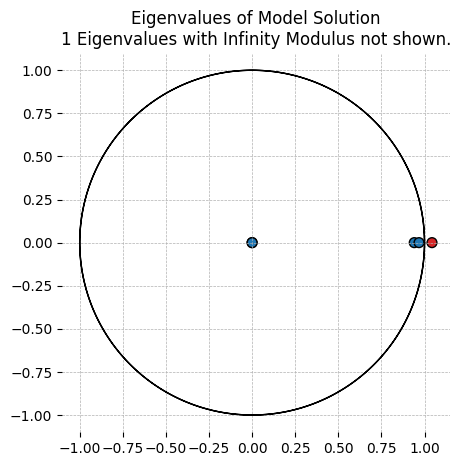

In [10]:
gp.plot_eigenvalues(rbc);

As we can see the output the number of unstable variables is the same as the number of control variable as a consequence the system has a unique solution.

In [11]:
#Run IRFs with our starting parameters to compare with the estimated parameters at the end.
base_irf = rbc.impulse_response_function(simulation_length=40, shock_size=0.1)

# Maximum Likelihood Estimation <a class="anchor" id="chapter2"></a>

In [12]:
# assign date freq
train = train.asfreq("QS")
train.head()

Y         I         r         C   w         L
TIME                                                            
1996-01-01  0.034739  0.025376  0.030090  0.073761 NaN  0.006896
1996-04-01 -0.023203  0.006568  0.023159 -0.032295 NaN       NaN
1996-07-01 -0.047401 -0.006060  0.019601 -0.077407 NaN       NaN
1996-10-01 -0.040238 -0.003936  0.010456 -0.046165 NaN       NaN
1997-01-01 -0.037205 -0.012070  0.009416 -0.052189 NaN -0.005354

## Simple model <a class="anchor" id="section_2_1"></a>

In the simple model the only parameter that we want to estimate is the 𝜌_𝐴 which represents the correlation between successive level of technology.

In [13]:
MLEModel = ge.compile_to_statsmodels(rbc)
rbc.free_param_dict.update(calibrated_params)

In [14]:
# parameters that we want to estimate, if not specified value will be taken from GCN file
param_start_dict = {
    'rho_A':0.85
                   }

# starting value for the shock's standard deviation
shock_start_dict = {
    'epsilon_A':0.5
                    }

# assume that the true value deviates with a σ, specified below
noise_start_dict = {
#     'Y':0.01,
#     'C':0.02,
#     'L':0.05,
#     'I':0.02,
#     'r':0.03,
#     'w':0.1
                    }

# define parameter search space e.g. 0 < α < 1, as suggested by Cobb-Douglas function
param_transforms = {
#     'sigma_C': IntervalTransformer(low=1.05, high=10.0, slope=1),
#     'sigma_L': IntervalTransformer(low=1.05, high=10.0, slope=1),
    'rho_A':IntervalTransformer(low=1e-2, high=0.99999, slope=1),
    # 'alpha':IntervalTransformer(low=0.0001, high=0.99, slope=1)
}

mle_mod = MLEModel(train[["Y"]],
                   param_start_dict = param_start_dict,
                   shock_start_dict = shock_start_dict,
                   noise_start_dict = noise_start_dict,
                   param_transforms = param_transforms,
                   shock_transforms=None, 
                   noise_transforms=None, 
                   initialization='stationary')

In [15]:
# %%capture
# basinhopping as algorithm, mixes different approaches 
mle_res = mle_mod.fit(method='basinhopping', minimizer={'method':'L-BFGS-B'}, maxiter=maxiter)

basinhopping step 0: f -1.375
basinhopping step 1: f -1.95835 trial_f -1.95835 accepted 1  lowest_f -1.95835
found new global minimum on step 1 with function value -1.95835
basinhopping step 2: f -1.9626 trial_f -1.9626 accepted 1  lowest_f -1.9626
found new global minimum on step 2 with function value -1.9626
basinhopping step 3: f -1.95832 trial_f -1.95832 accepted 1  lowest_f -1.9626
basinhopping step 4: f -1.95936 trial_f -1.95936 accepted 1  lowest_f -1.9626
basinhopping step 5: f -1.96613 trial_f -1.96613 accepted 1  lowest_f -1.96613
found new global minimum on step 5 with function value -1.96613
basinhopping step 6: f -1.96648 trial_f -1.96648 accepted 1  lowest_f -1.96648
found new global minimum on step 6 with function value -1.96648
basinhopping step 7: f -1.9667 trial_f -1.9667 accepted 1  lowest_f -1.9667
found new global minimum on step 7 with function value -1.9667
basinhopping step 8: f -1.867 trial_f -1.867 accepted 1  lowest_f -1.9667
basinhopping step 9: f -1.96579 t

In [22]:
ùmle_res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:                      Y   No. Observations:                   80
Model:                      DSGEModel   Log Likelihood                  73.898
Date:                Sat, 10 Dec 2022   AIC                           -143.797
Time:                        11:04:44   BIC                           -139.033
Sample:                    01-01-1996   HQIC                          -141.887
                         - 10-01-2015                                         
Covariance Type:                  opg                                         
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
rho_A                0.9856      0.031     31.414      0.000       0.924       1.047
sigma2.epsilon_A     0.0184      0.026      0.716      0.474      -0.032       0.069
===================================================================================
Ljung-Box (L1) (Q):                  10.11   Jarque-Bera (JB):               265.48
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.55   Skew:                            -1.85
Prob(H) (two-sided):                  0.13   Kurtosis:                        11.12
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (centered finite differences).
"""

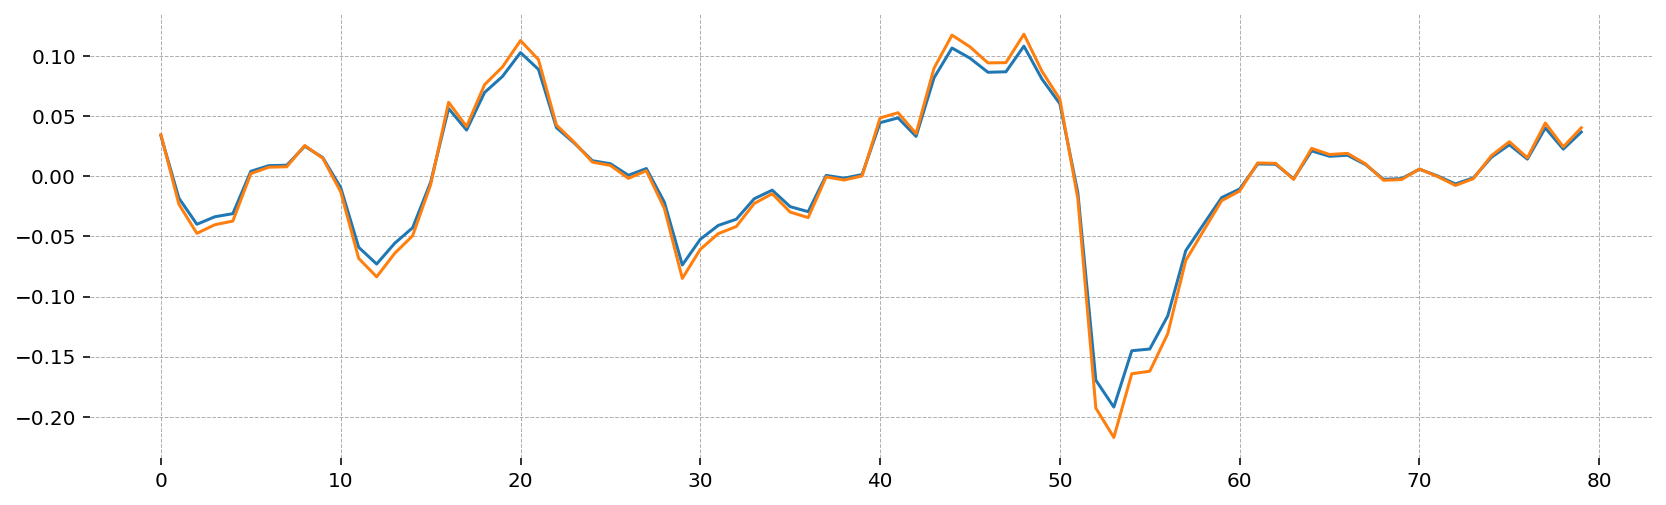

In [23]:

plt.plot(mle_res.filtered_state[0])
plt.plot(train.Y.values)

Without any information noise, the model follow perfectly the dynamics of the GDP

### MLE Kalman Filter Prediction Plots <a class="anchor" id="subsection_2_1"></a>

Predictions

The model does not correctly pick-up on the data's variance and its direction. Confidence intervals are rather broad (+/-500% with Cx)and predicted variation moves even in opposite direction of actual data with I an C. Predictions differ significantly in magnitude from the actual data, thus even variance has not been captured correctly. L and I are much less responsive to variations in Y in reality than suggested by the model. This might point to a too responsive specification of the consumption function.

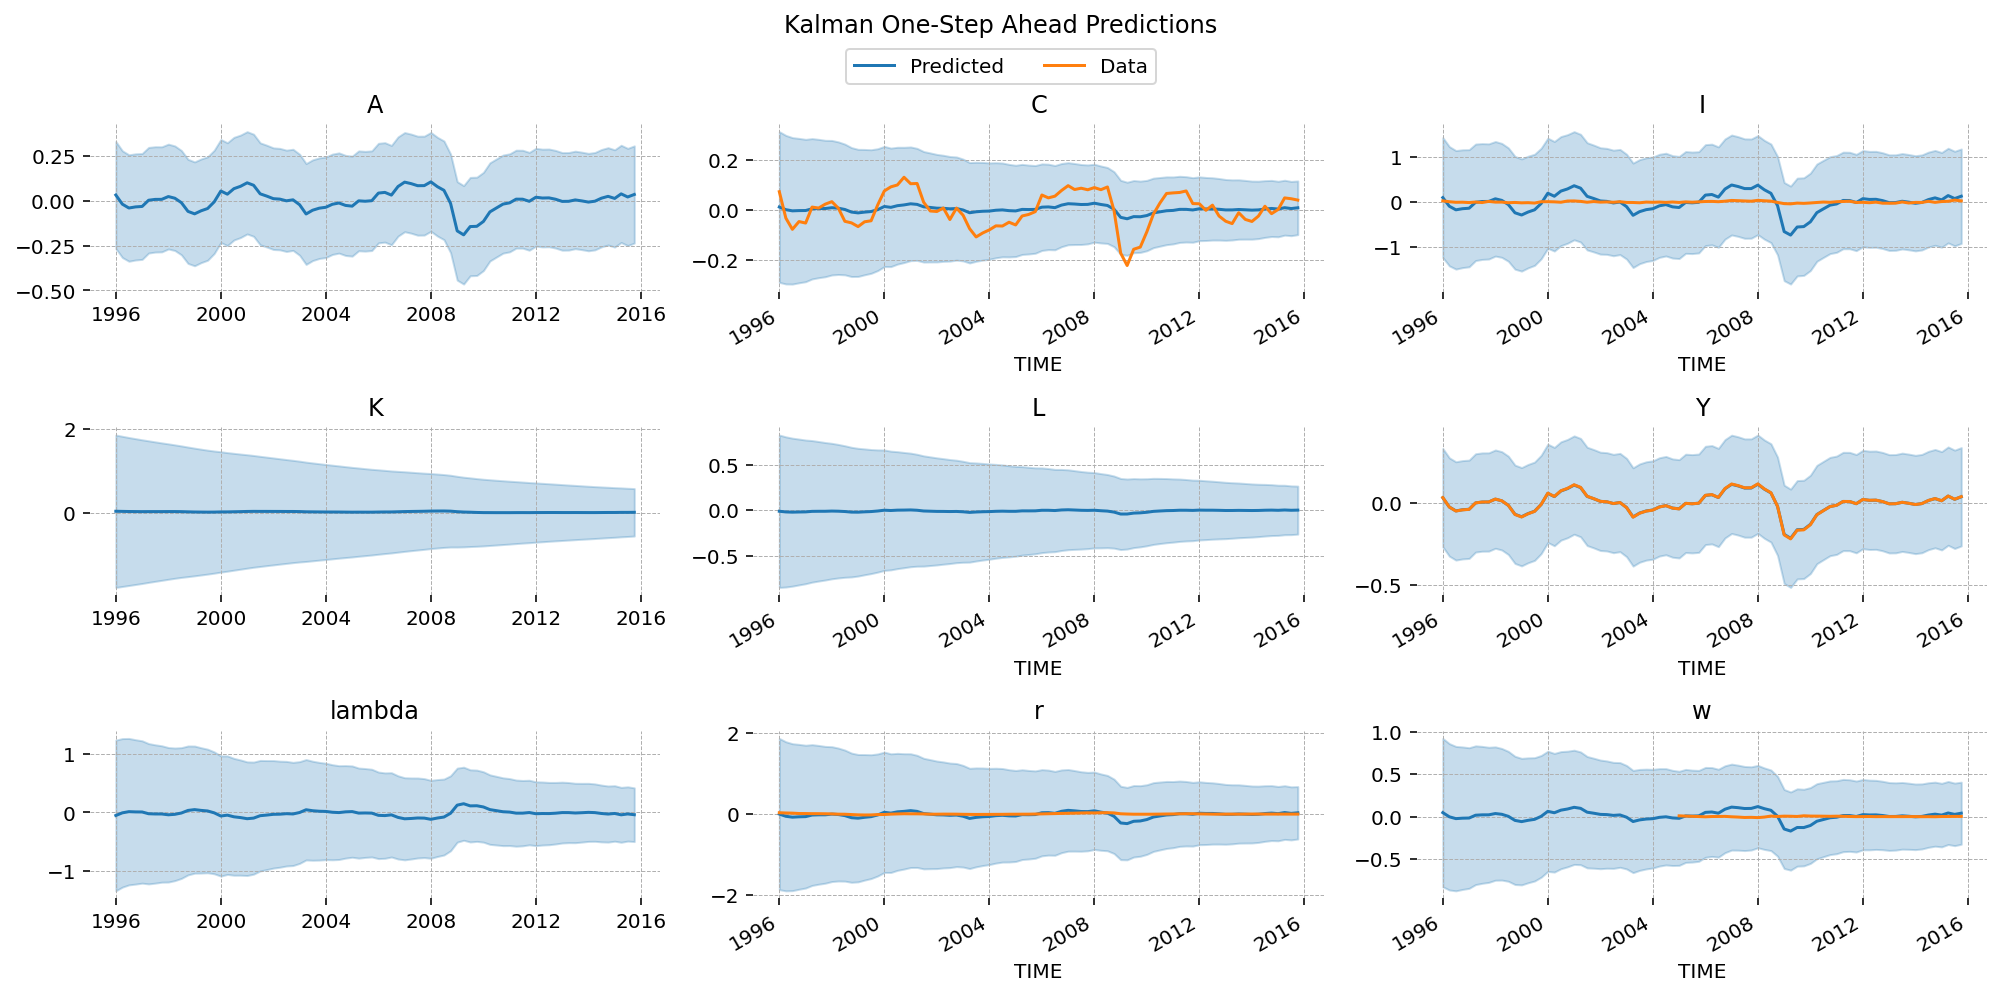

In [24]:
plot_sm_results(mle_res, train, var_names=plot_vars)

Smoothed output

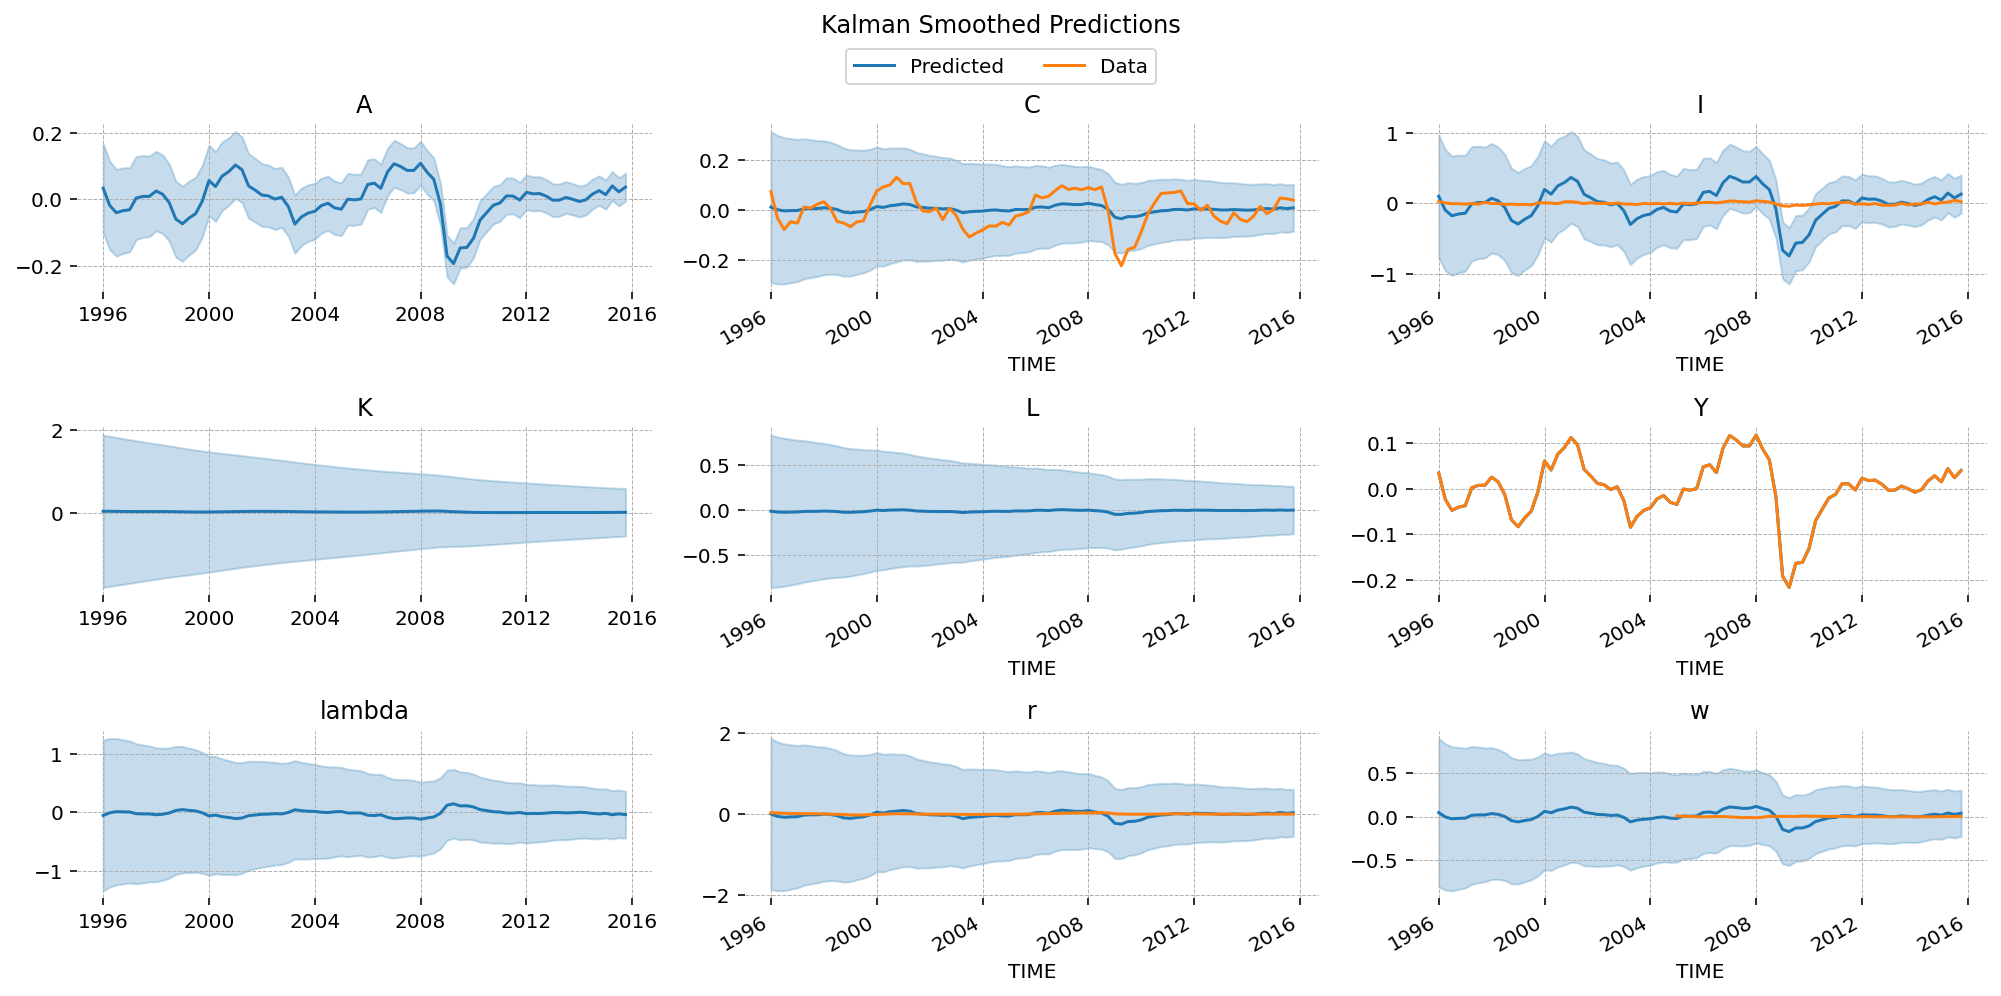

In [25]:
plot_sm_results(mle_res, train, 'smoothed', var_names=plot_vars)

### Forecasting <a class="anchor" id="subsection_2_2"></a>

In [26]:
mle_forecast = mle_res.get_forecast(steps=test_size)

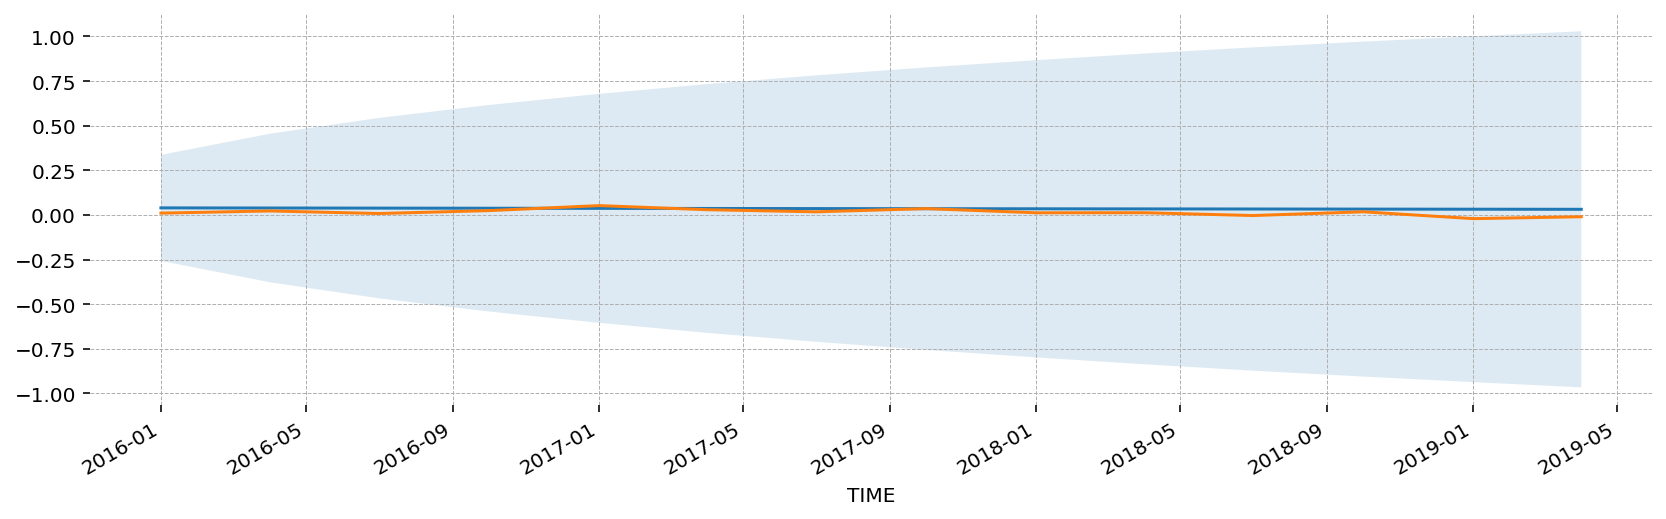

In [28]:
mu = mle_forecast.predicted_mean

# var_pred_mean is the variance, but the 95% CI will be +/- 1.96 * std, so we have to take square root.
sigma = 1.96 * np.sqrt(mle_forecast.var_pred_mean)

fig, ax = plt.subplots()
ax.plot(mu)
ax.fill_between(mu.index, mu - sigma, mu + sigma, alpha=0.15)
test.Y.plot(ax=ax)
plt.show()

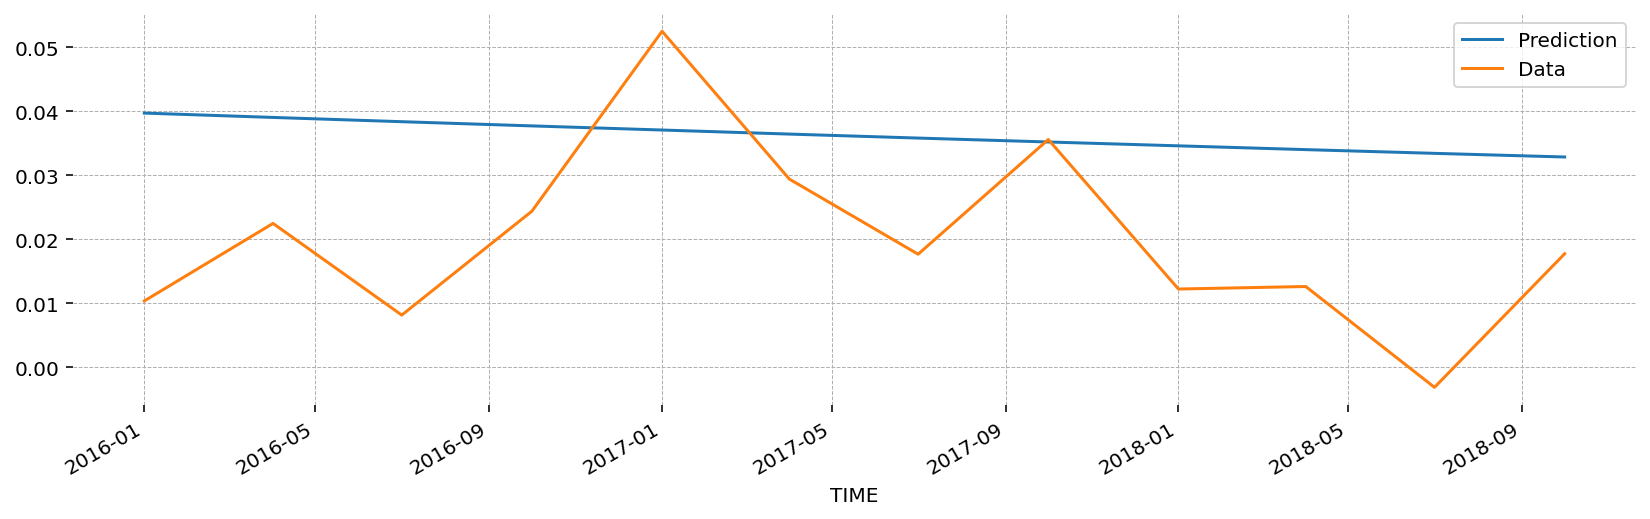

In [29]:
fig, ax = plt.subplots()
n_quarters = 12

ax.plot(mu.iloc[:n_quarters], label='Prediction')
test.Y.iloc[:n_quarters].plot(ax=ax, label='Data')
ax.legend()
plt.show()

Our model has not correctly captured the notion of an overbooming economy, that evenutally declines. This could be an interpretation of the down-turn in 2017, which has been preceeded by years of recovery and subsquent boom of post 08. However, the model did identify a decline in Y, at least at mean prediction the confidence interval is far too broad to qualify for this to qualify as an actual prediction.

## Analysing sigma_C <a class="anchor" id="section_2_2"></a>

To address the high volatility of C in the Kalman Filter predictions we include sigma_C, the consumption utility parameter. As consumption is too responsive, the chosen parameter for sigma_C might be too low (implying higher repsonsiveness of C).

In [30]:
MLEModel = ge.compile_to_statsmodels(rbc)
rbc.free_param_dict.update(calibrated_params)

In [31]:
from gEcon.classes.transformers import PositiveTransformer, IntervalTransformer

# parameters that we want to estimate, if not specified value will be taken from GCN file
param_start_dict = {
    'rho_A':0.85,
    'sigma_C': 1.5
                   }

# starting value for the shock's standard deviation
shock_start_dict = {
    'epsilon_A':0.5
                    }

# assume that the true value deviates with a σ, specified below
noise_start_dict = {
    'Y':0.01
                    }

# define parameter search space e.g. 0 < α < 1, as suggested by Cobb-Douglas function
param_transforms = {
    'rho_A':IntervalTransformer(low=1e-2, high=0.99999, slope=1),
    'sigma_C':IntervalTransformer(low=1, high=10, slope=1)
                    }

mle_mod = MLEModel(train[["Y"]],
                   param_start_dict = param_start_dict,
                   shock_start_dict = shock_start_dict,
                   noise_start_dict = noise_start_dict,
                   param_transforms = param_transforms,
                   shock_transforms=None, 
                   noise_transforms=None, 
                   initialization='stationary')

In [32]:
# %%capture
mle_res = mle_mod.fit(method='basinhopping', minimizer={'method':'L-BFGS-B'}, maxiter=maxiter)

basinhopping step 0: f -1.06811
basinhopping step 1: f -1.64228 trial_f -1.64228 accepted 1  lowest_f -1.64228
found new global minimum on step 1 with function value -1.64228
basinhopping step 2: f -1.64228 trial_f -1.37335 accepted 0  lowest_f -1.64228
basinhopping step 3: f -1.76262 trial_f -1.76262 accepted 1  lowest_f -1.76262
found new global minimum on step 3 with function value -1.76262
basinhopping step 4: f -1.7734 trial_f -1.7734 accepted 1  lowest_f -1.7734
found new global minimum on step 4 with function value -1.7734
basinhopping step 5: f -1.88522 trial_f -1.88522 accepted 1  lowest_f -1.88522
found new global minimum on step 5 with function value -1.88522
basinhopping step 6: f -1.52266 trial_f -1.52266 accepted 1  lowest_f -1.88522
basinhopping step 7: f -1.93722 trial_f -1.93722 accepted 1  lowest_f -1.93722
found new global minimum on step 7 with function value -1.93722
basinhopping step 8: f -1.92646 trial_f -1.92646 accepted 1  lowest_f -1.93722
basinhopping step 9:

In [33]:
mle_res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:                      Y   No. Observations:                   80
Model:                      DSGEModel   Log Likelihood                  63.332
Date:                Sat, 10 Dec 2022   AIC                           -118.664
Time:                        11:08:22   BIC                           -109.135
Sample:                    01-01-1996   HQIC                          -114.843
                         - 10-01-2015                                         
Covariance Type:                  opg                                         
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
rho_A                0.9852     19.729      0.050      0.960     -37.683      39.654
sigma_C              2.2026   1.37e+04      0.000      1.000   -2.69e+04    2.69e+04
sigma2.epsilon_A     0.0184     60.489      0.000      1.000    -118.537     118.574
sigma2.Y           2.86e-05      0.067      0.000      1.000      -0.130       0.130
===================================================================================
Ljung-Box (L1) (Q):                  10.15   Jarque-Bera (JB):               263.69
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.55   Skew:                            -1.84
Prob(H) (two-sided):                  0.13   Kurtosis:                        11.09
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (centered finite differences).
"""

### MLE Kalman Filter Prediction Plots <a class="anchor" id="subsection_2_3"></a>

Predictions

Indeed we see that the parameter for sigma_C that has been identified by the model is much higher than what was suggested by the literature. This could be an explanation for the odd behaviour of the consumption function. However, the newly calibrated model suggests much lower volatility in consumption than actual data depicts. Moreover, the model considers actual consumption to be "impossible" as outside its confidence interval.
Confidence Intervals on L and I went down, yet their remain of very broad range not allowing for any prediction of signifcance. Volatiltiy of predictions also stil much surpasses actual data with I, r and w.

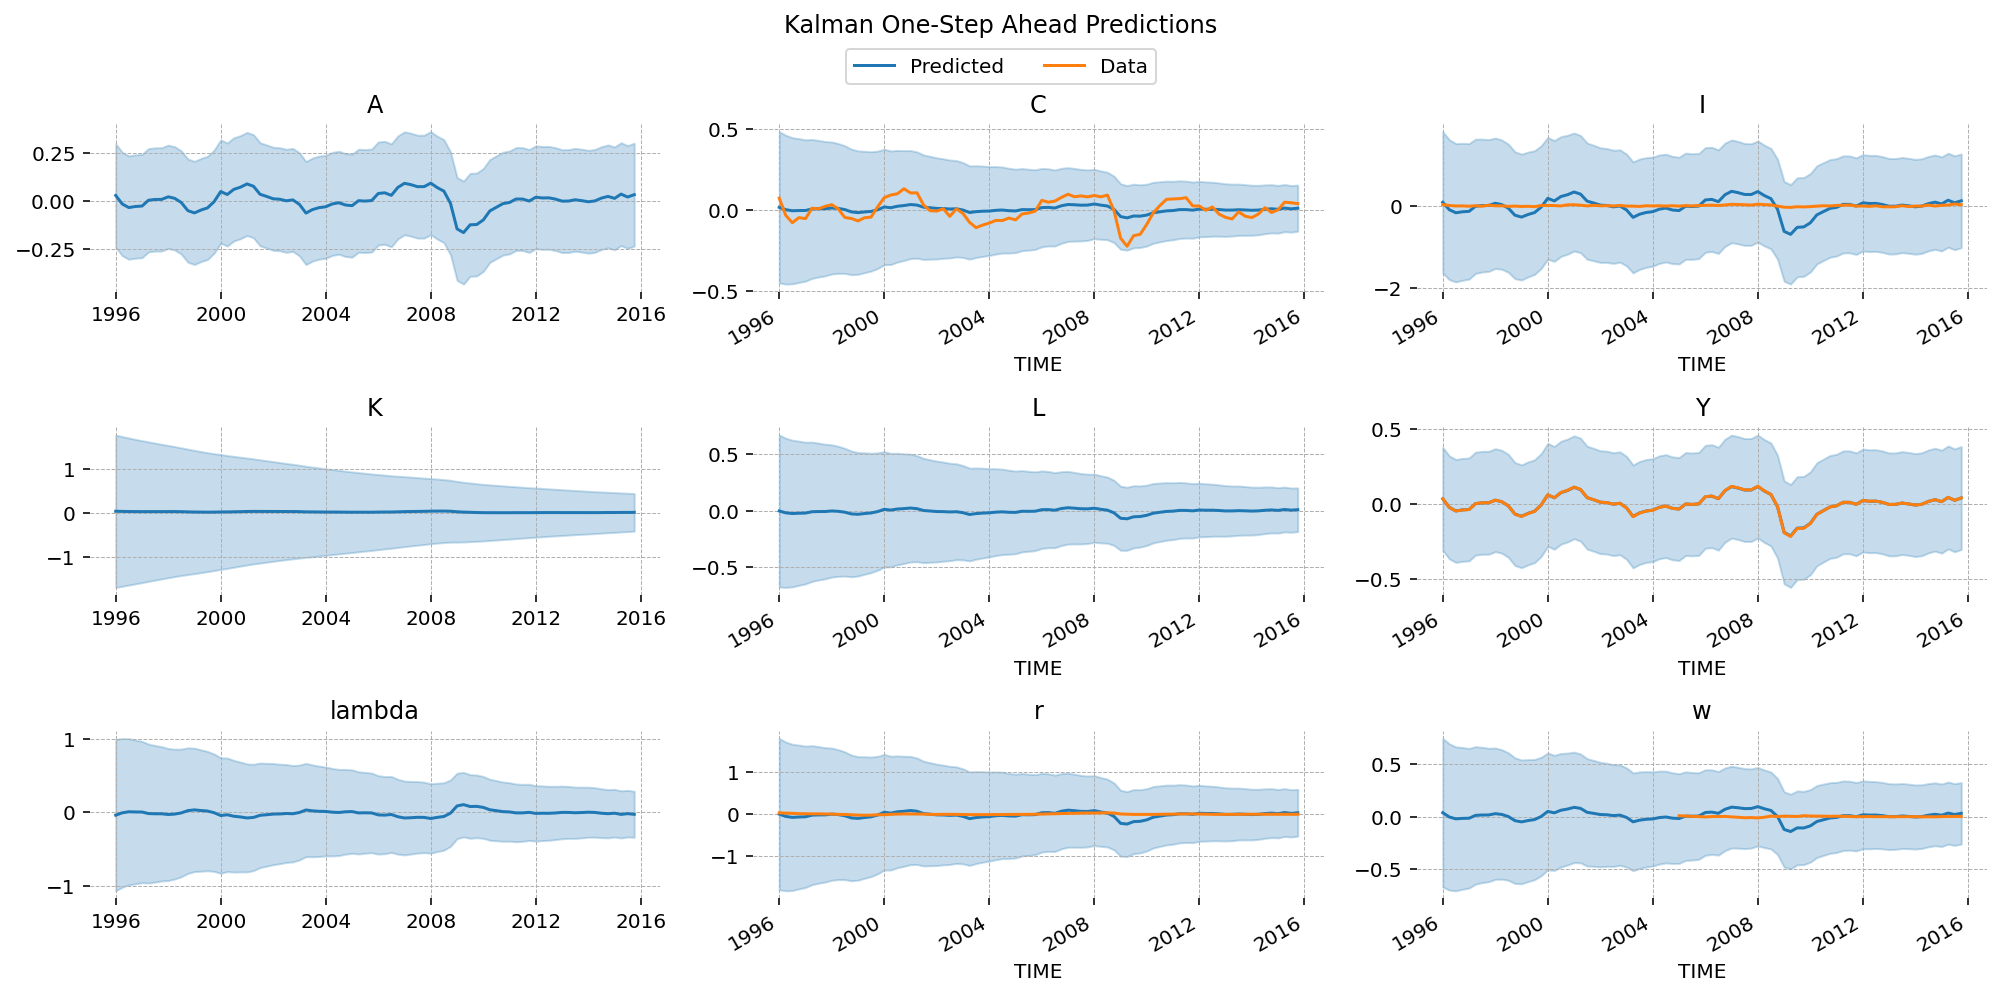

In [34]:
plot_sm_results(mle_res, train, var_names=plot_vars)

Smoothed output

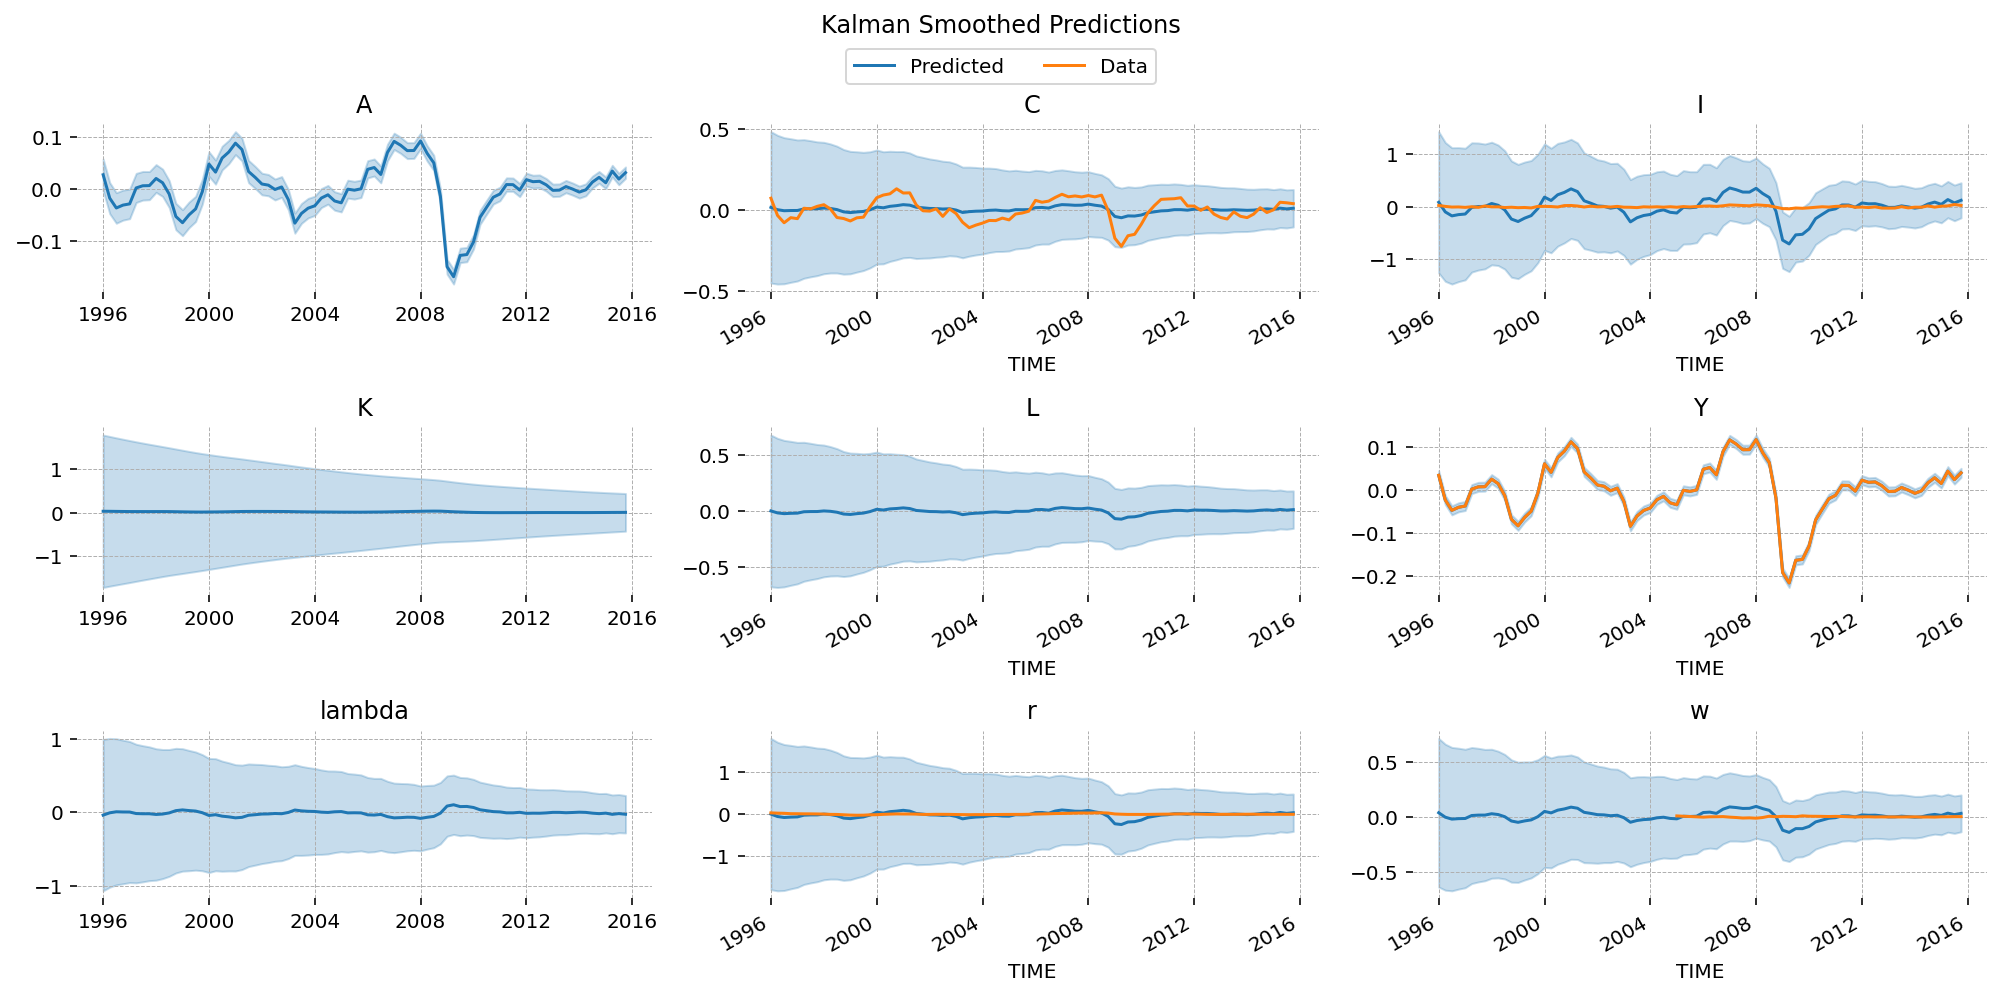

In [35]:
plot_sm_results(mle_res, train, 'smoothed', var_names=plot_vars)

### Forecasting <a class="anchor" id="subsection_2_4"></a>

In [36]:
mle_forecast = mle_res.get_forecast(steps=test_size)

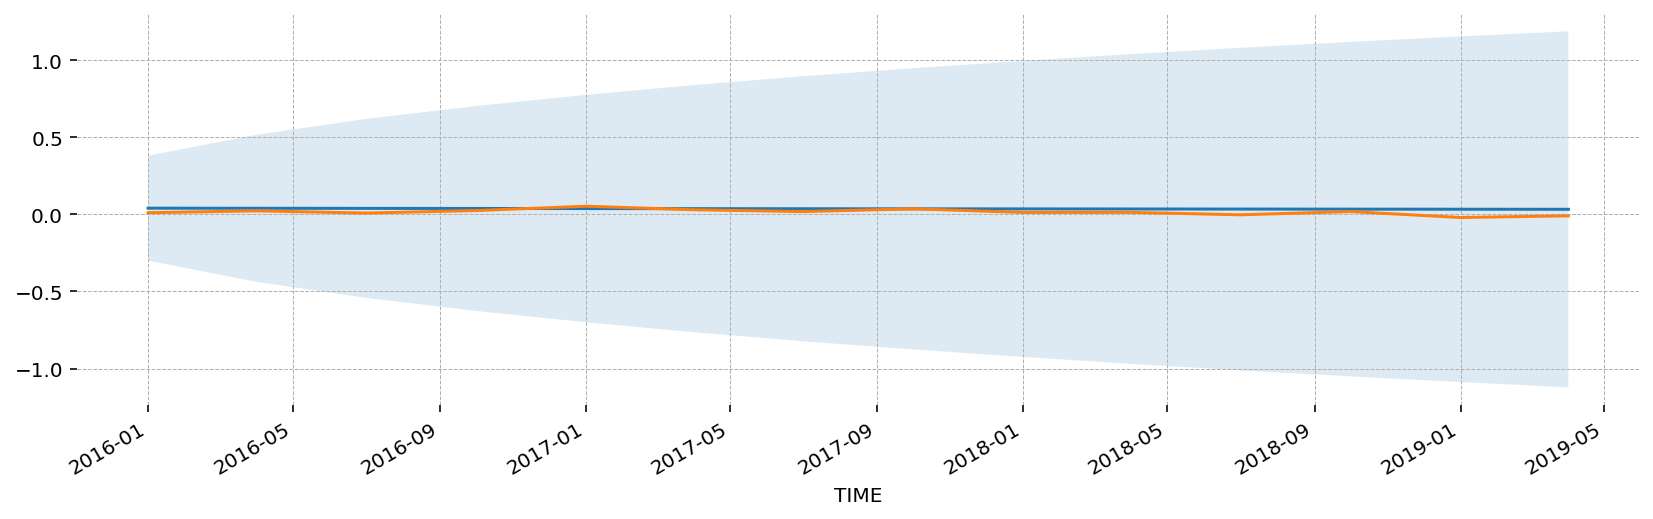

In [37]:
mu = mle_forecast.predicted_mean

# var_pred_mean is the variance, but the 95% CI will be +/- 1.96 * std, so we have to take square root.
sigma = 1.96 * np.sqrt(mle_forecast.var_pred_mean)

fig, ax = plt.subplots()
ax.plot(mu)
ax.fill_between(mu.index, mu - sigma, mu + sigma, alpha=0.15)
test.Y.plot(ax=ax)
plt.show()

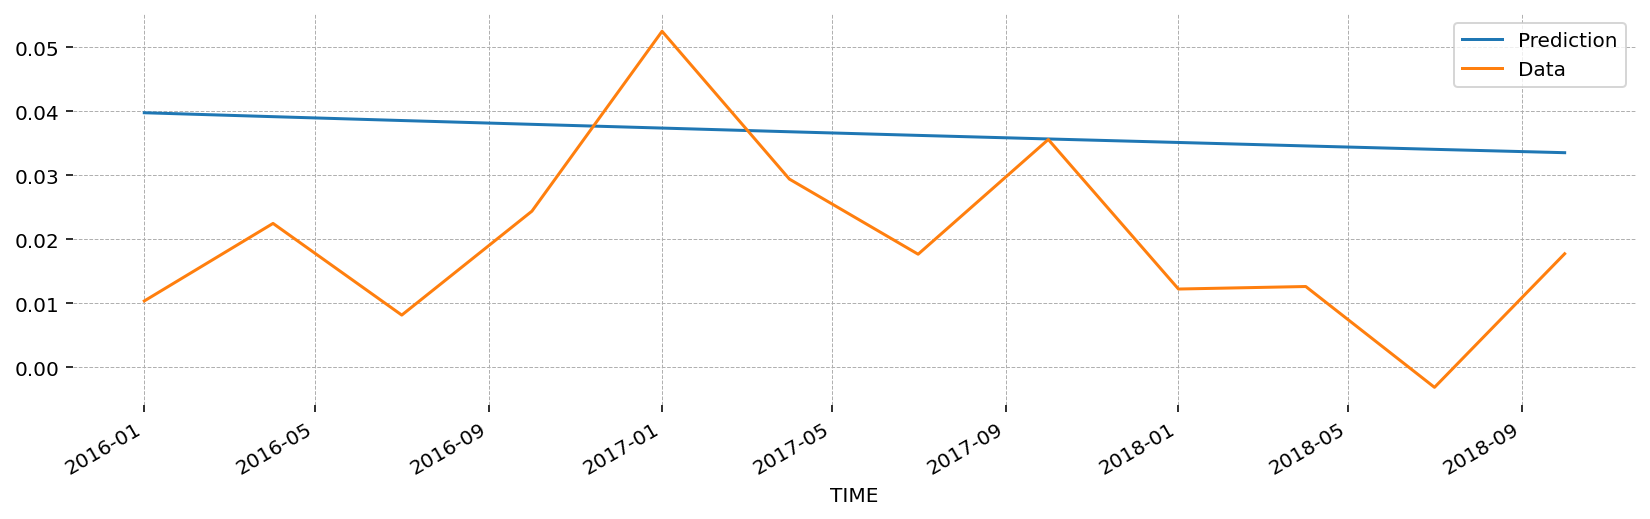

In [38]:
fig, ax = plt.subplots()
n_quarters = 12

ax.plot(mu.iloc[:n_quarters], label='Prediction')
test.Y.iloc[:n_quarters].plot(ax=ax, label='Data')
ax.legend()
plt.show()

Not tanking into account the broad confidence interval on Y predictions, this model seems at least to have capture the economic downtrend across our testing period. Despite this better prediction, the model is far from a viable forecast of GDP.

## Adding L  <a class="anchor" id="section_2_3"></a>

We now include labour into the model to see whether this leads to any improvement with regards to our Consumption prediction. As Labour and Consumption are directly related in their choosing (through the Euler Equation) more information on Labour might help us predict consumption more accurately. We do not include sigma_L just yet, since it has actually a very small effect on consumer choice?

In [39]:
MLEModel = ge.compile_to_statsmodels(rbc)
rbc.free_param_dict.update(calibrated_params)

In [40]:
from gEcon.classes.transformers import PositiveTransformer, IntervalTransformer

# parameters that we want to estimate, if not specified value will be taken from GCN file
param_start_dict = {
    'rho_A':0.85,
    'sigma_C': 1.5
                   }

# starting value for the shock's standard deviation
shock_start_dict = {
    'epsilon_A':0.5
                    }

# assume that the true value deviates with a σ, specified below
noise_start_dict = {
    'Y':0.01
                    }

# define parameter search space e.g. 0 < α < 1, as suggested by Cobb-Douglas function
param_transforms = {
    'rho_A':IntervalTransformer(low=1e-2, high=0.99999, slope=1),
    'sigma_C':IntervalTransformer(low=1, high=10, slope=1)
                    }

mle_mod = MLEModel(train[["Y", "L"]],
                   param_start_dict = param_start_dict,
                   shock_start_dict = shock_start_dict,
                   noise_start_dict = noise_start_dict,
                   param_transforms = param_transforms,
                   shock_transforms=None, 
                   noise_transforms=None, 
                   initialization='stationary')

In [41]:
# %%capture
# basinhopping as algorithm, mixes different approaches 
mle_res = mle_mod.fit(method='basinhopping', minimizer={'method':'L-BFGS-B'}, maxiter=maxiter)

basinhopping step 0: f -1.3771
basinhopping step 1: f -1.95987 trial_f -1.95987 accepted 1  lowest_f -1.95987
found new global minimum on step 1 with function value -1.95987
basinhopping step 2: f -2.00225 trial_f -2.00225 accepted 1  lowest_f -2.00225
found new global minimum on step 2 with function value -2.00225
basinhopping step 3: f -2.00225 trial_f -1.40185 accepted 0  lowest_f -2.00225
basinhopping step 4: f -2.05832 trial_f -2.05832 accepted 1  lowest_f -2.05832
found new global minimum on step 4 with function value -2.05832
basinhopping step 5: f -2.05832 trial_f -0.862548 accepted 0  lowest_f -2.05832
basinhopping step 6: f -2.05832 trial_f -0.255128 accepted 0  lowest_f -2.05832
basinhopping step 7: f -1.32702 trial_f -1.32702 accepted 1  lowest_f -2.05832
basinhopping step 8: f -1.32702 trial_f 0.209131 accepted 0  lowest_f -2.05832
basinhopping step 9: f -1.86611 trial_f -1.86611 accepted 1  lowest_f -2.05832
basinhopping step 10: f -1.39802 trial_f -1.39802 accepted 1  lo

In [42]:
mle_res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:             ['Y', 'L']   No. Observations:                   80
Model:                      DSGEModel   Log Likelihood                  80.480
Date:                Sat, 10 Dec 2022   AIC                           -152.960
Time:                        11:15:04   BIC                           -143.432
Sample:                    01-01-1996   HQIC                          -149.140
                         - 10-01-2015                                         
Covariance Type:                  opg                                         
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
rho_A                0.9905      0.044     22.566      0.000       0.905       1.077
sigma_C              6.9007     70.085      0.098      0.922    -130.463     144.265
sigma2.epsilon_A     0.0052      0.007      0.754      0.451      -0.008       0.019
sigma2.Y             0.0596      0.021      2.781      0.005       0.018       0.102
===================================================================================
Ljung-Box (L1) (Q):            59.87, 0.00   Jarque-Bera (JB):        13.47, 193.40
Prob(Q):                        0.00, 1.00   Prob(JB):                   0.00, 0.00
Heteroskedasticity (H):         4.78, 2.13   Skew:                     -0.51, -0.50
Prob(H) (two-sided):            0.00, 0.05   Kurtosis:                  4.73, 10.55
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (centered finite differences).
"""

### MLE Kalman Filter Prediction Plots <a class="anchor" id="subsection_2_5"></a>

The inclusion of C has lead to no improvement, neither have confidence intervals decreased nor are mean predictions any closer to the underlying data. If at all the inclusion of L has worsened the prediction of L as the model now closely follows L instead of Y.

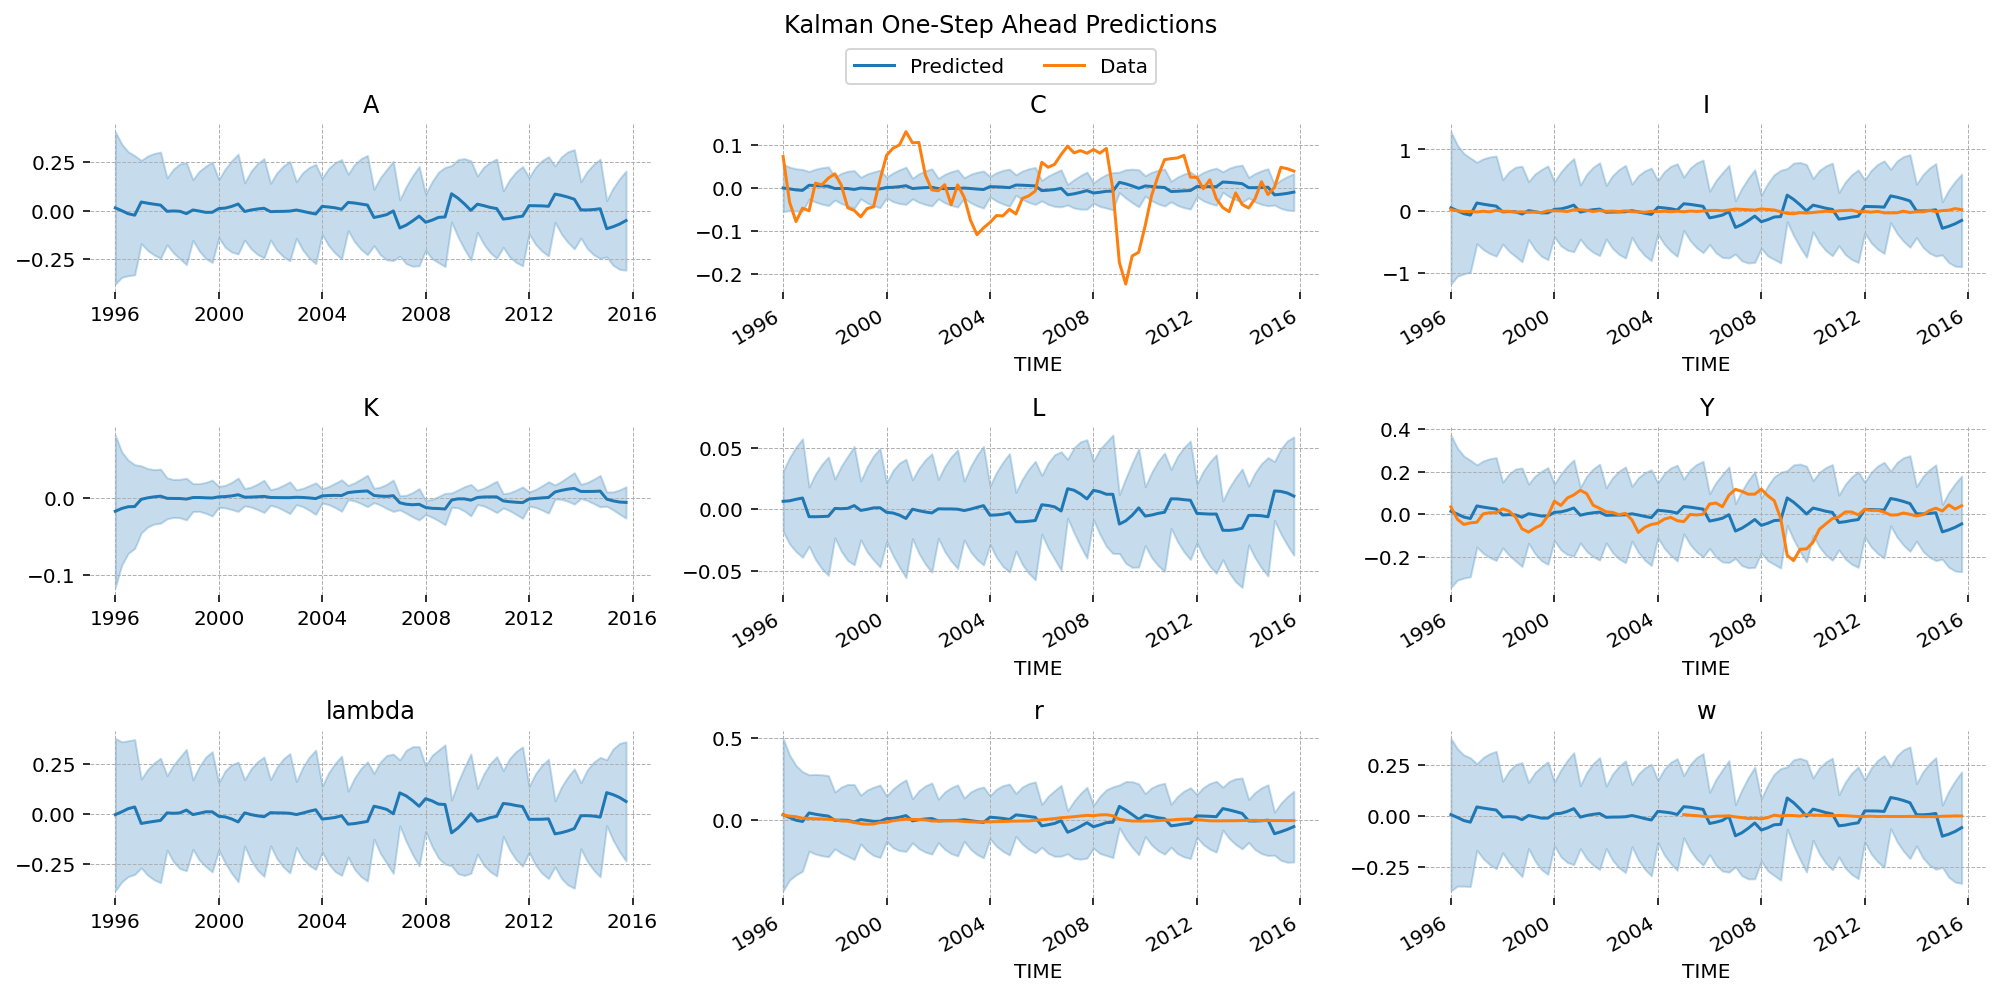

In [43]:
plot_sm_results(mle_res, train, var_names=plot_vars)

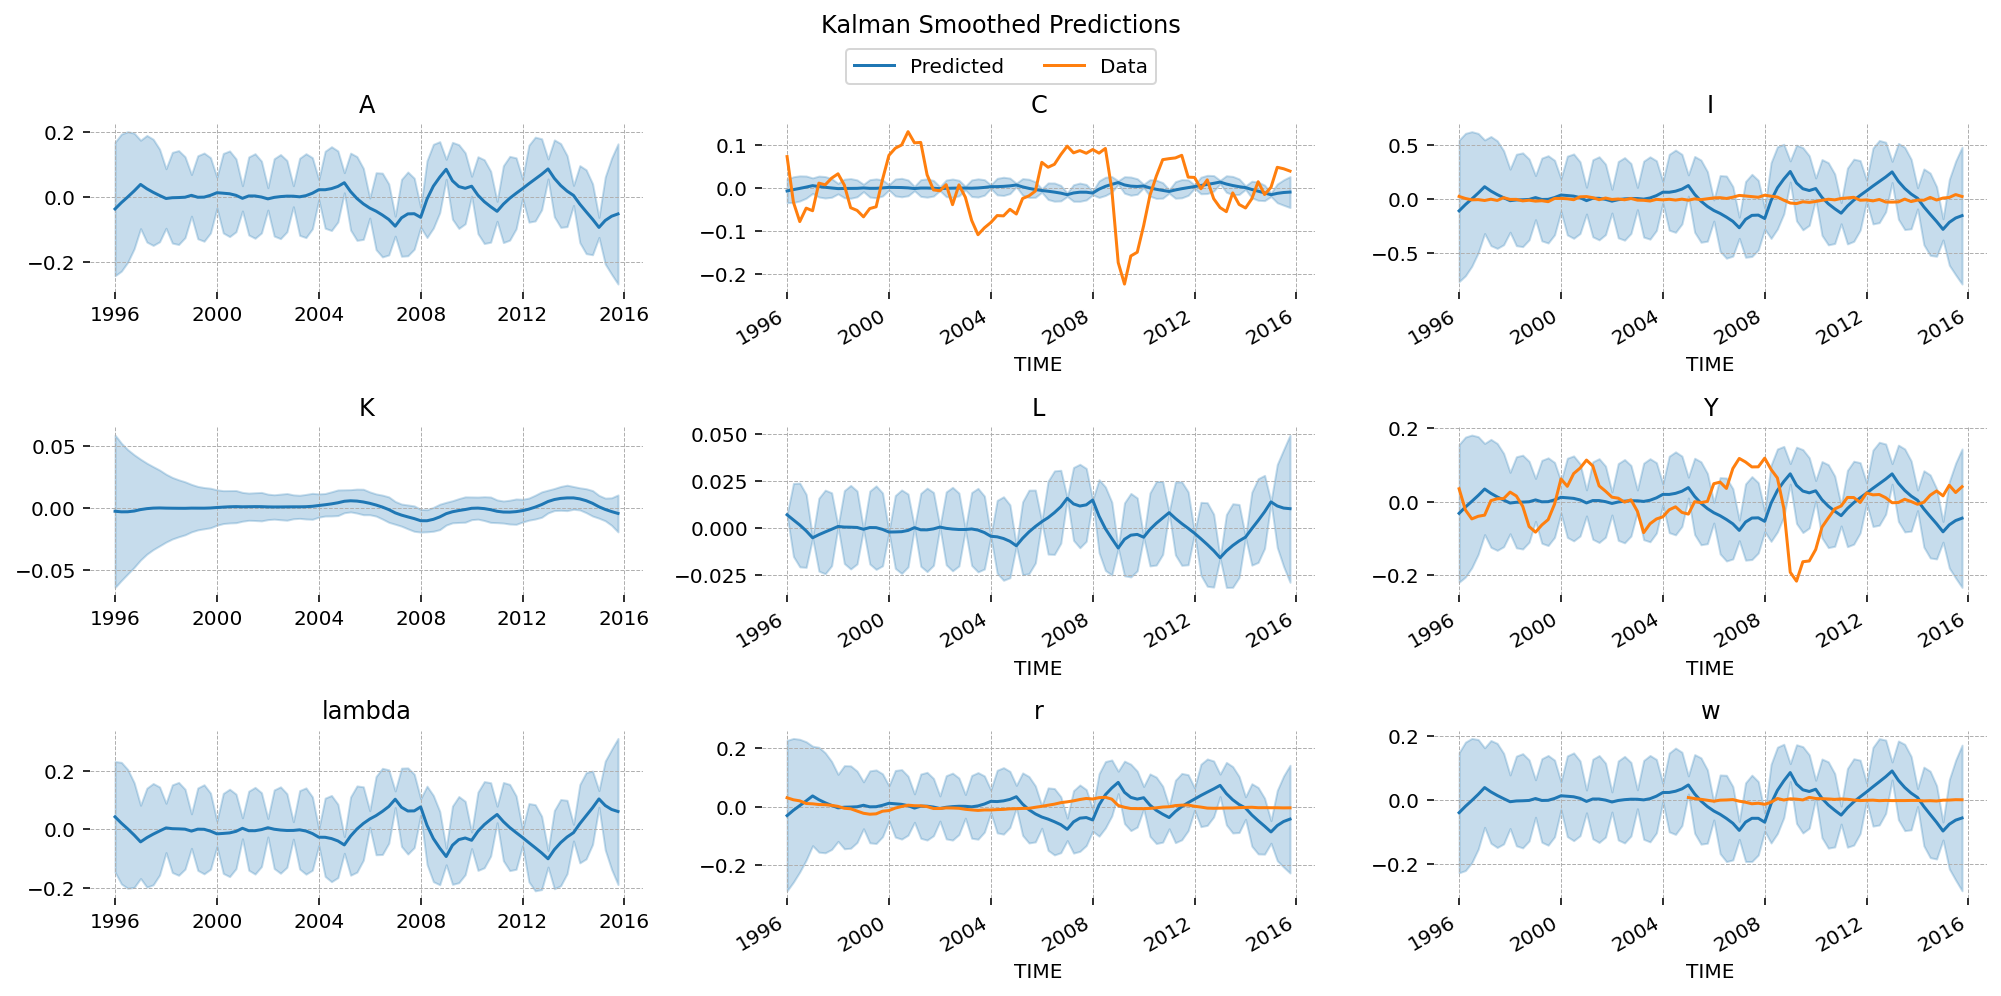

In [44]:
plot_sm_results(mle_res, train, 'smoothed', var_names=plot_vars)

### Forecasting <a class="anchor" id="subsection_2_6"></a>

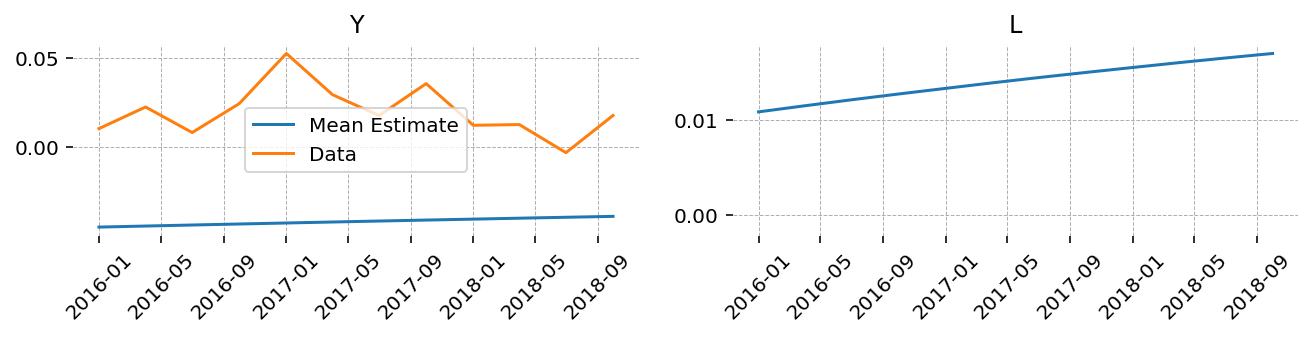

In [45]:
everything_forecast = mle_res.get_forecast(steps=test_size)
mu = everything_forecast.predicted_mean

n_quarters = 12
gs, locs = gp.prepare_gridspec_figure(n_cols=3, n_plots=6)

fig = plt.figure(figsize=(14, 6))
for var, loc in zip(['Y', 'L'], locs):
    axis = fig.add_subplot(gs[loc])
    axis.plot(mu[var].iloc[:n_quarters], label='Mean Estimate')
    axis.plot(test[var].iloc[:n_quarters], label='Data')
    axis.tick_params(axis='x', rotation=45)
    axis.set_title(var)

fig.axes[0].legend()
fig.tight_layout()
plt.show()

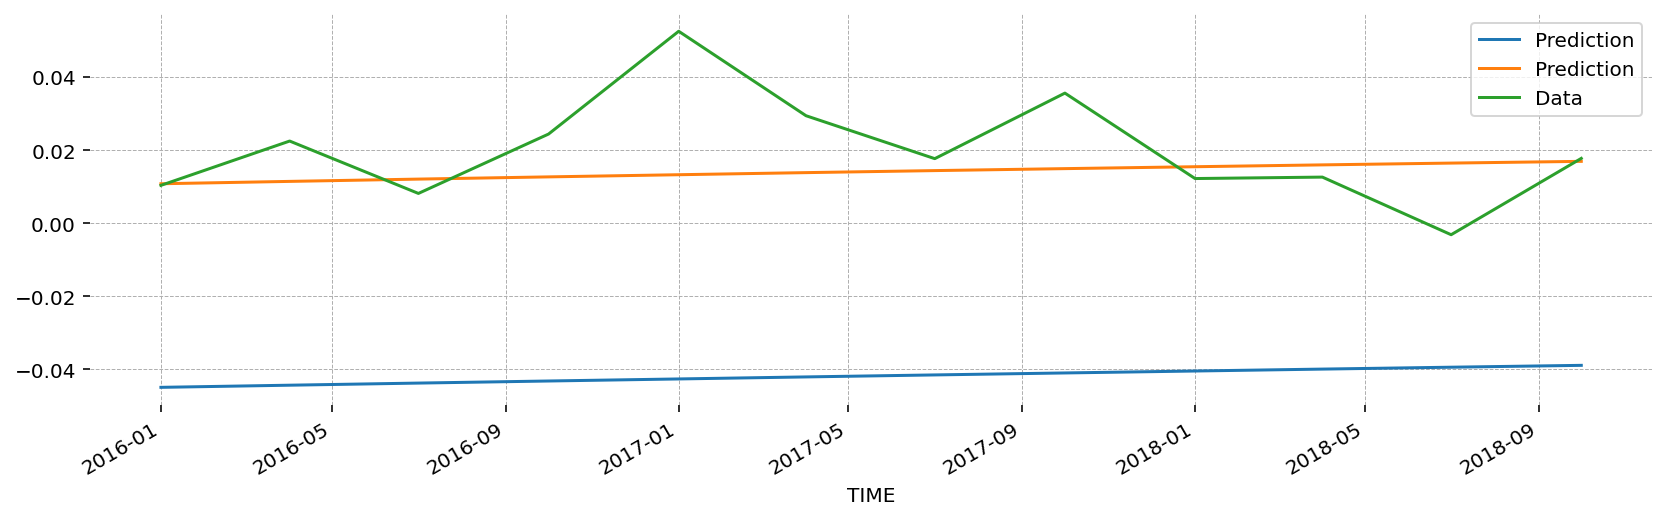

In [46]:
fig, ax = plt.subplots()
n_quarters = 12

ax.plot(mu.iloc[:n_quarters], label='Prediction')
test.Y.iloc[:n_quarters].plot(ax=ax, label='Data')
ax.legend()
plt.show()

## Adding C  <a class="anchor" id="section_2_3"></a>

We include labour into the model to see whether also predictions for C improve

In [48]:
MLEModel = ge.compile_to_statsmodels(rbc)
rbc.free_param_dict.update(calibrated_params)

In [49]:
from gEcon.classes.transformers import PositiveTransformer, IntervalTransformer

# parameters that we want to estimate, if not specified value will be taken from GCN file
param_start_dict = {
    'rho_A':0.85,
    'sigma_C': 1.5
                   }

# starting value for the shock's standard deviation
shock_start_dict = {
    'epsilon_A':0.5
                    }

# assume that the true value deviates with a σ, specified below
noise_start_dict = {
    'Y':0.01
                    }

# define parameter search space e.g. 0 < α < 1, as suggested by Cobb-Douglas function
param_transforms = {
    'rho_A':IntervalTransformer(low=1e-2, high=0.99999, slope=1),
    'sigma_C':IntervalTransformer(low=1, high=10, slope=1)
                    }

mle_mod = MLEModel(train[["Y", "C"]],
                   param_start_dict = param_start_dict,
                   shock_start_dict = shock_start_dict,
                   noise_start_dict = noise_start_dict,
                   param_transforms = param_transforms,
                   shock_transforms=None, 
                   noise_transforms=None, 
                   initialization='stationary')

In [50]:
# %%capture
# basinhopping as algorithm, mixes different approaches 
mle_res = mle_mod.fit(method='basinhopping', minimizer={'method':'L-BFGS-B'}, maxiter=maxiter)

basinhopping step 0: f 30.1024
basinhopping step 1: f 12.6071 trial_f 12.6071 accepted 1  lowest_f 12.6071
found new global minimum on step 1 with function value 12.6071
basinhopping step 2: f 11.9123 trial_f 11.9123 accepted 1  lowest_f 11.9123
found new global minimum on step 2 with function value 11.9123
basinhopping step 3: f 11.9123 trial_f 13.3284 accepted 0  lowest_f 11.9123
basinhopping step 4: f 1.56265 trial_f 1.56265 accepted 1  lowest_f 1.56265
found new global minimum on step 4 with function value 1.56265
basinhopping step 5: f 1.56265 trial_f 2.99751 accepted 0  lowest_f 1.56265
basinhopping step 6: f 1.56265 trial_f 4.25813 accepted 0  lowest_f 1.56265
basinhopping step 7: f 1.49249 trial_f 1.49249 accepted 1  lowest_f 1.49249
found new global minimum on step 7 with function value 1.49249
basinhopping step 8: f 1.56543 trial_f 1.56543 accepted 1  lowest_f 1.49249
basinhopping step 9: f 1.55342 trial_f 1.55342 accepted 1  lowest_f 1.49249
basinhopping step 10: f 2.29259 t

In [51]:
mle_res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:             ['Y', 'C']   No. Observations:                   80
Model:                      DSGEModel   Log Likelihood                -219.651
Date:                Sat, 10 Dec 2022   AIC                            447.301
Time:                        11:17:21   BIC                            456.829
Sample:                    01-01-1996   HQIC                           451.121
                         - 10-01-2015                                         
Covariance Type:                  opg                                         
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
rho_A                0.9953      0.156      6.383      0.000       0.690       1.301
sigma_C              1.0005     16.513      0.061      0.952     -31.364      33.365
sigma2.epsilon_A     2.3430     40.210      0.058      0.954     -76.468      81.154
sigma2.Y             6.3174     98.829      0.064      0.949    -187.384     200.019
===================================================================================
Ljung-Box (L1) (Q):           43.04, 17.32   Jarque-Bera (JB):          1.67, 22.67
Prob(Q):                        0.00, 0.00   Prob(JB):                   0.43, 0.00
Heteroskedasticity (H):         2.29, 0.85   Skew:                      0.35, -0.94
Prob(H) (two-sided):            0.04, 0.67   Kurtosis:                   3.05, 4.81
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (centered finite differences).
"""

### MLE Kalman Filter Prediction Plots <a class="anchor" id="subsection_2_5"></a>

Including C into the model has show positive effects. Confidence intervals decreased, the model thus seems to have taken something from this additional data source. Yet predictions are in no way more meaningful when compared to before. Consumption this time is closly fitted, yet other variables such as Y suffer in accuracy, even though not as much as with the inclusion of L.

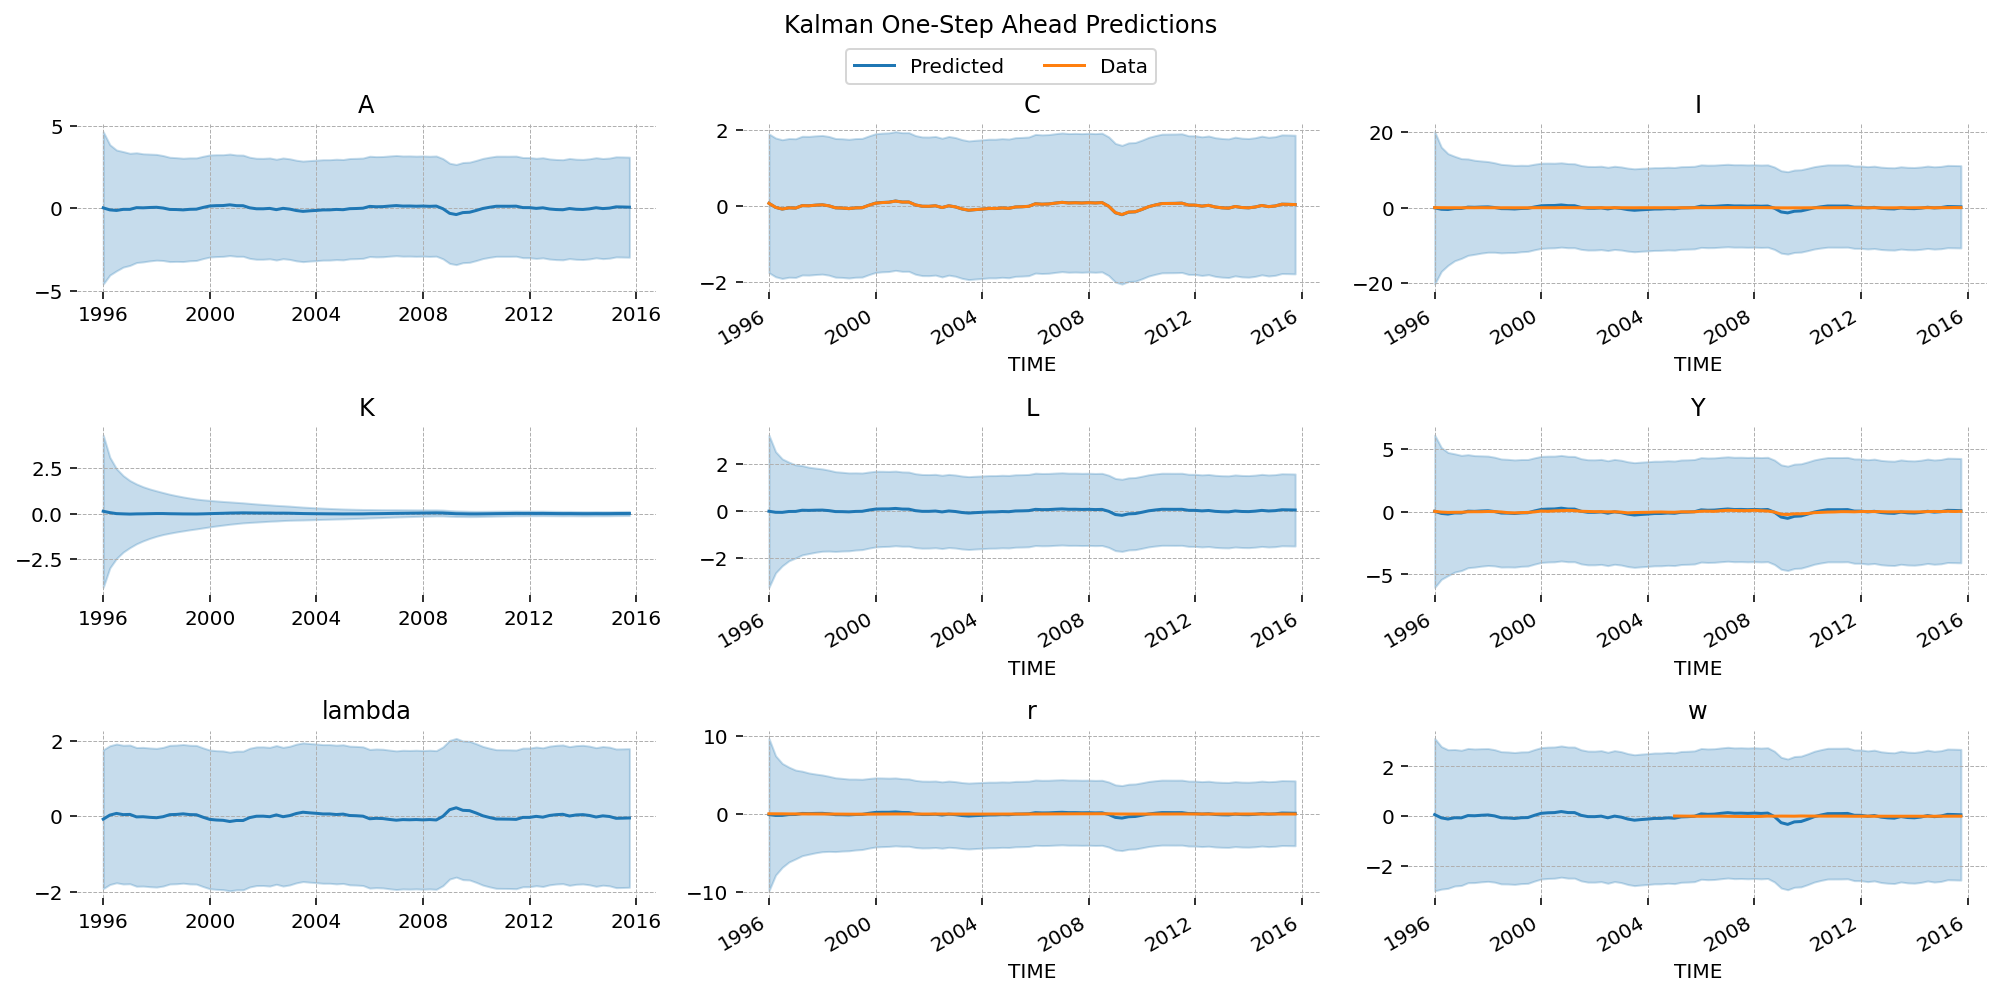

In [52]:
plot_sm_results(mle_res, train, var_names=plot_vars)

Smoothed output

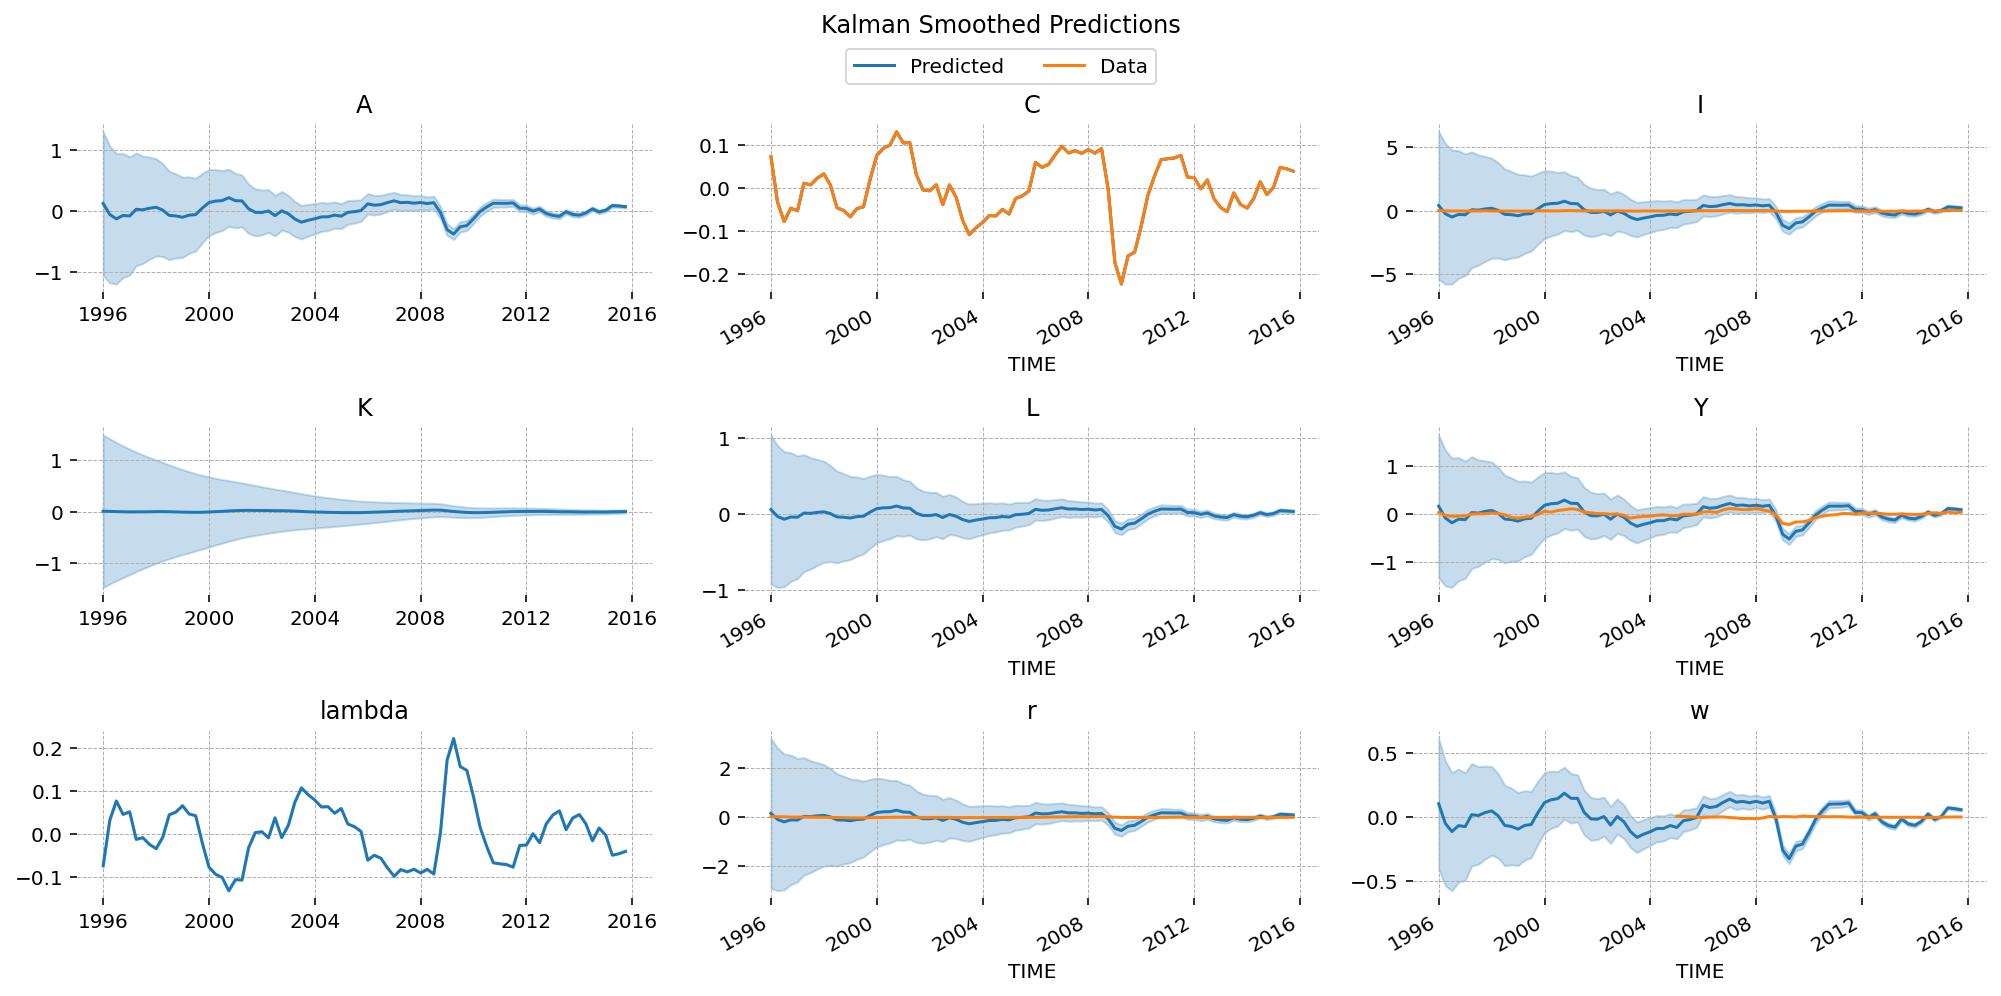

In [53]:
plot_sm_results(mle_res, train, 'smoothed', var_names=plot_vars)

### Forecasting <a class="anchor" id="subsection_2_6"></a>

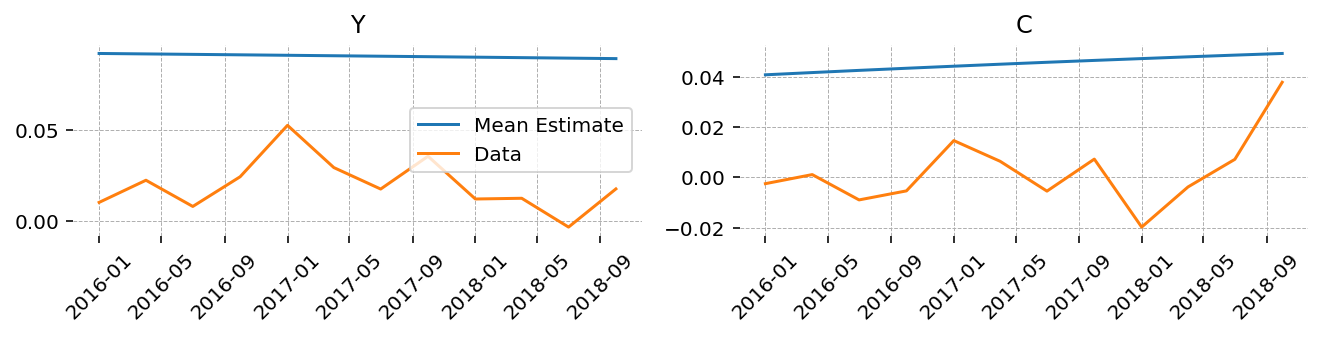

In [54]:
everything_forecast = mle_res.get_forecast(steps=test_size)
mu = everything_forecast.predicted_mean

n_quarters = 12
gs, locs = gp.prepare_gridspec_figure(n_cols=3, n_plots=6)

fig = plt.figure(figsize=(14, 6))
for var, loc in zip(['Y', 'C'], locs):
    axis = fig.add_subplot(gs[loc])
    axis.plot(mu[var].iloc[:n_quarters], label='Mean Estimate')
    axis.plot(test[var].iloc[:n_quarters], label='Data')
    axis.tick_params(axis='x', rotation=45)
    axis.set_title(var)

fig.axes[0].legend()
fig.tight_layout()
plt.show()

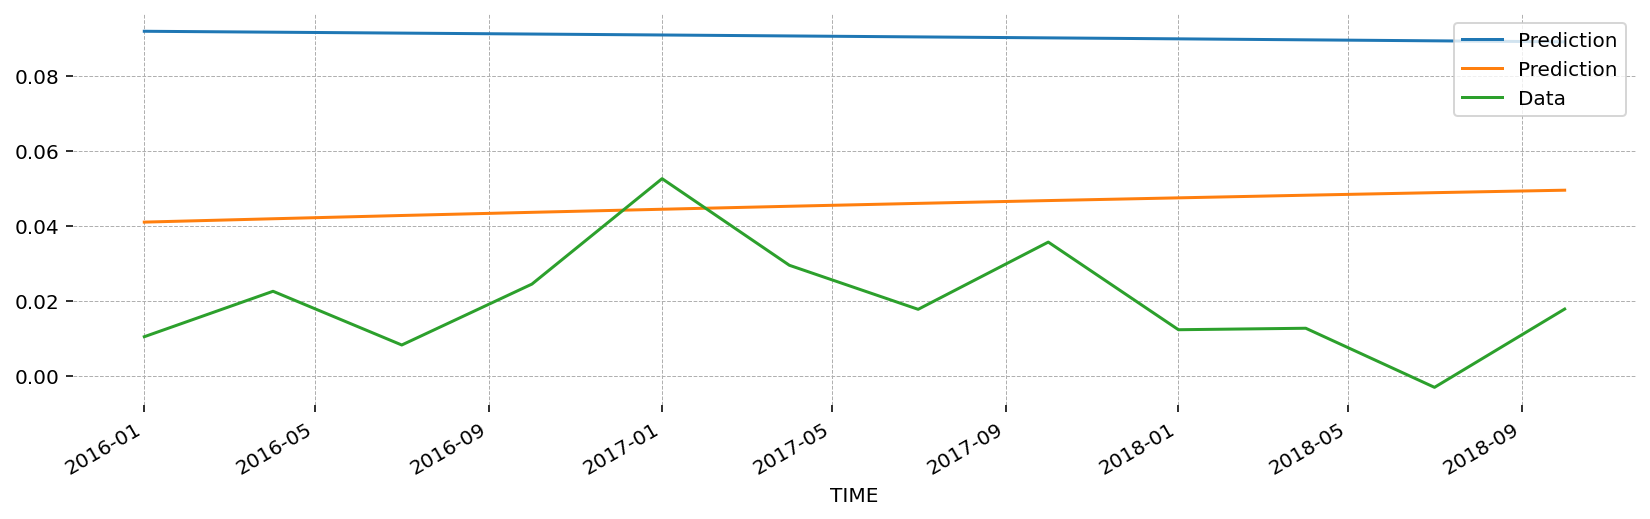

In [55]:
fig, ax = plt.subplots()
n_quarters = 12

ax.plot(mu.iloc[:n_quarters], label='Prediction')
test.Y.iloc[:n_quarters].plot(ax=ax, label='Data')
ax.legend()
plt.show()

## Final model <a class="anchor" id="section_2_4"></a>

Having gradually added data to the Kalman filter estimation we are now running the model on the complete data available to us. 

In [56]:
MLEModel = ge.compile_to_statsmodels(rbc)
rbc.free_param_dict.update(calibrated_params)

In [57]:
# Try estimating everything, why not?
param_start_dict = {'rho_A':0.85,
                    'sigma_C':1,
                    'sigma_L':1,
                    'alpha':0.35,
                    'beta':0.98,
                    'delta':0.035}

shock_start_dict = {'epsilon_A':0.5}

# We have to add noise to everything but Y, or else we'll get the stochastic singularity
noise_start_dict = {'w':0.01,
                    'r':0.01,
                    'C':0.01,
                    'I':0.01}

param_transforms = {'rho_A':IntervalTransformer(low=0.01, high=0.99),
                    'sigma_C':IntervalTransformer(low=1.0, high=10.0),
                    'sigma_L':IntervalTransformer(low=1.0, high=10),
                    'alpha':IntervalTransformer(low=0.1, high=0.5),
                    'beta':IntervalTransformer(low=0.9, high=0.999),
                    'delta':IntervalTransformer(low=0.01, high=0.05)}

# Build the model!
mle_mod = MLEModel(train[['Y', 'w', 'r', 'C', 'I']],
               param_start_dict = param_start_dict,
               shock_start_dict = shock_start_dict,
               noise_start_dict = noise_start_dict,
               param_transforms = param_transforms,
               shock_transforms=None, # If None, will automatically transform to positive values only
               noise_transforms=None, # If None, will automatically transform to positive values only
               initialization='stationary')

In [58]:
# %%capture
# basinhopping as algorithm, mixes different approaches 
mle_res = mle_mod.fit(method='basinhopping', minimizer={'method':'L-BFGS-B'}, maxiter=maxiter)

basinhopping step 0: f 321.79
basinhopping step 1: f 7.85815 trial_f 7.85815 accepted 1  lowest_f 7.85815
found new global minimum on step 1 with function value 7.85815
basinhopping step 2: f 6.26659 trial_f 6.26659 accepted 1  lowest_f 6.26659
found new global minimum on step 2 with function value 6.26659
basinhopping step 3: f 6.67071 trial_f 6.67071 accepted 1  lowest_f 6.26659
basinhopping step 4: f 5.71654 trial_f 5.71654 accepted 1  lowest_f 5.71654
found new global minimum on step 4 with function value 5.71654
basinhopping step 5: f 5.88754 trial_f 5.88754 accepted 1  lowest_f 5.71654
basinhopping step 6: f 3.54026 trial_f 3.54026 accepted 1  lowest_f 3.54026
found new global minimum on step 6 with function value 3.54026
basinhopping step 7: f 3.54026 trial_f 4.47068 accepted 0  lowest_f 3.54026
basinhopping step 8: f 3.68673 trial_f 3.68673 accepted 1  lowest_f 3.54026
basinhopping step 9: f 3.18175 trial_f 3.18175 accepted 1  lowest_f 3.18175
found new global minimum on step 9

In [59]:
mle_res.summary()

C:\Users\LukasGrahl\Documents\GIT\macro_rbc\env_macro_rbc\lib\site-packages\statsmodels\tsa\stattools.py:1346: RuntimeWarning: divide by zero encountered in divide
  test_statistic = numer_squared_sum / denom_squared_sum


<class 'statsmodels.iolib.summary.Summary'>
"""
                               Statespace Model Results                              
=====================================================================================
Dep. Variable:     ['Y', 'w', 'r', 'C', 'I']   No. Observations:                   80
Model:                             DSGEModel   Log Likelihood                  48.213
Date:                       Sat, 10 Dec 2022   AIC                            -74.425
Time:                               11:23:32   BIC                            -48.223
Sample:                           01-01-1996   HQIC                           -63.920
                                - 10-01-2015                                         
Covariance Type:                         opg                                         
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
rho_A                0.6459      4.263      0.152      0.880      -7.710       9.001
sigma_C              1.0000     62.661      0.016      0.987    -121.813     123.813
sigma_L              1.0000     56.072      0.018      0.986    -108.898     110.898
alpha                0.4345     17.634      0.025      0.980     -34.127      34.996
beta                 0.9836      1.159      0.849      0.396      -1.288       3.255
delta                0.0124      0.254      0.049      0.961      -0.485       0.510
sigma2.epsilon_A     0.0344      0.870      0.040      0.968      -1.671       1.740
sigma2.w             0.1219      0.073      1.675      0.094      -0.021       0.265
sigma2.r             0.0798      1.315      0.061      0.952      -2.497       2.657
sigma2.C             0.0605      0.360      0.168      0.867      -0.646       0.767
sigma2.I             0.4842      9.338      0.052      0.959     -17.818      18.787
=================================================================================================================
Ljung-Box (L1) (Q):     25.66, 64.95, 62.21, 57.08, 62.21   Jarque-Bera (JB):   240.49, 41.18, 82.89, 9.19, 43.50
Prob(Q):                     0.00, 0.00, 0.00, 0.00, 0.00   Prob(JB):                0.00, 0.00, 0.00, 0.01, 0.00
Heteroskedasticity (H):       0.69, inf, 1.92, 1.55, 2.09   Skew:                  -1.84, 0.71, 1.61, -0.72, 1.25
Prob(H) (two-sided):         0.33, 0.00, 0.10, 0.26, 0.06   Kurtosis:               10.65, 6.22, 6.80, 3.83, 5.61
=================================================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (centered finite differences).
"""

### MLE Kalman Filter Prediction Plots <a class="anchor" id="subsection_2_7"></a>

Including all to us available data into the model has lead to some improvement. Confidence intervals have significantly decreased (I does no longer lie in a range of +/- 1000%). However, other anomalies become apparent. The actual consumption data lies without the confidence interval of the model's prediction, hence are considered impossible values. But note that the problems arises in correspondence with the time of crysis which in our model are not properly included.  Moreover prediction power on the other variables has not improved, only Y has the close fitting of prediction like in the baseline model.

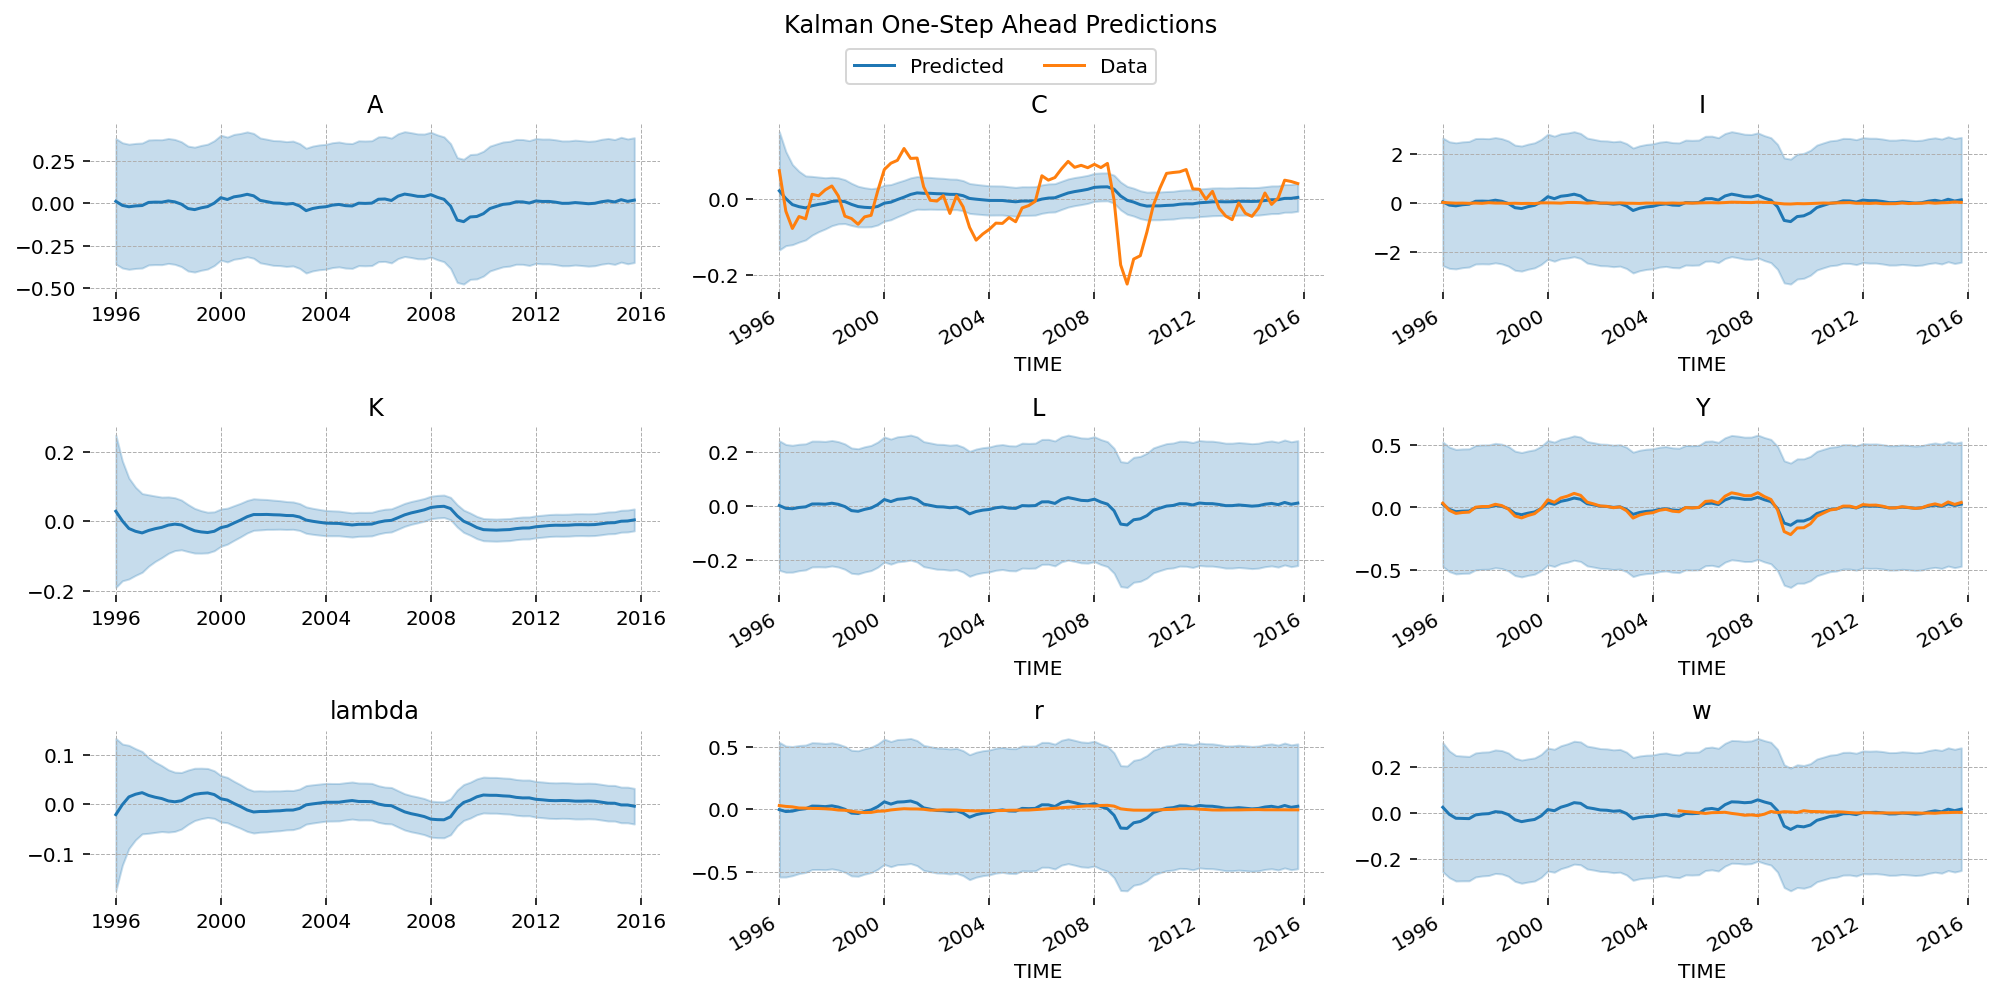

In [60]:
plot_sm_results(mle_res, train, var_names=plot_vars)

Smoothed output

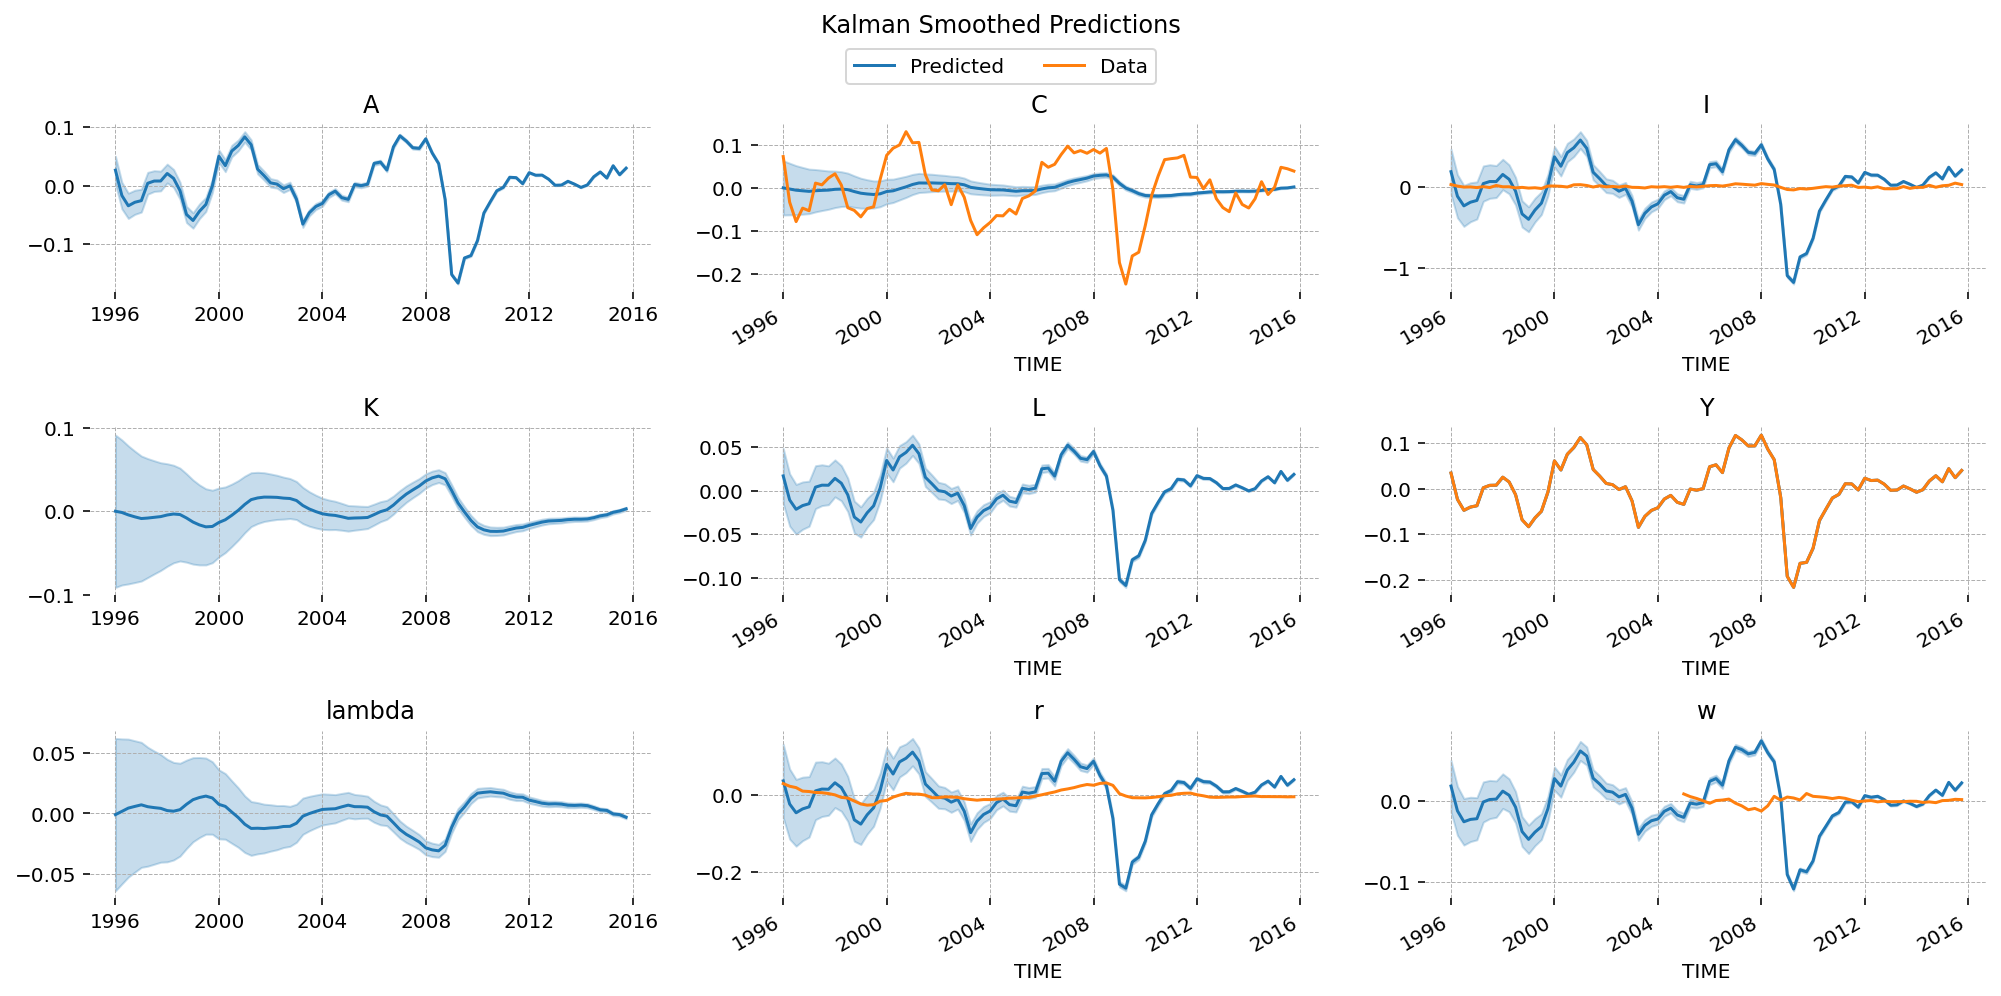

In [61]:
plot_sm_results(mle_res, train, 'smoothed', var_names=plot_vars)

### Forecasting <a class="anchor" id="subsection_2_8"></a>

In [62]:
mle_forecast = mle_res.get_forecast(steps=test_size)
mu = mle_forecast.predicted_mean

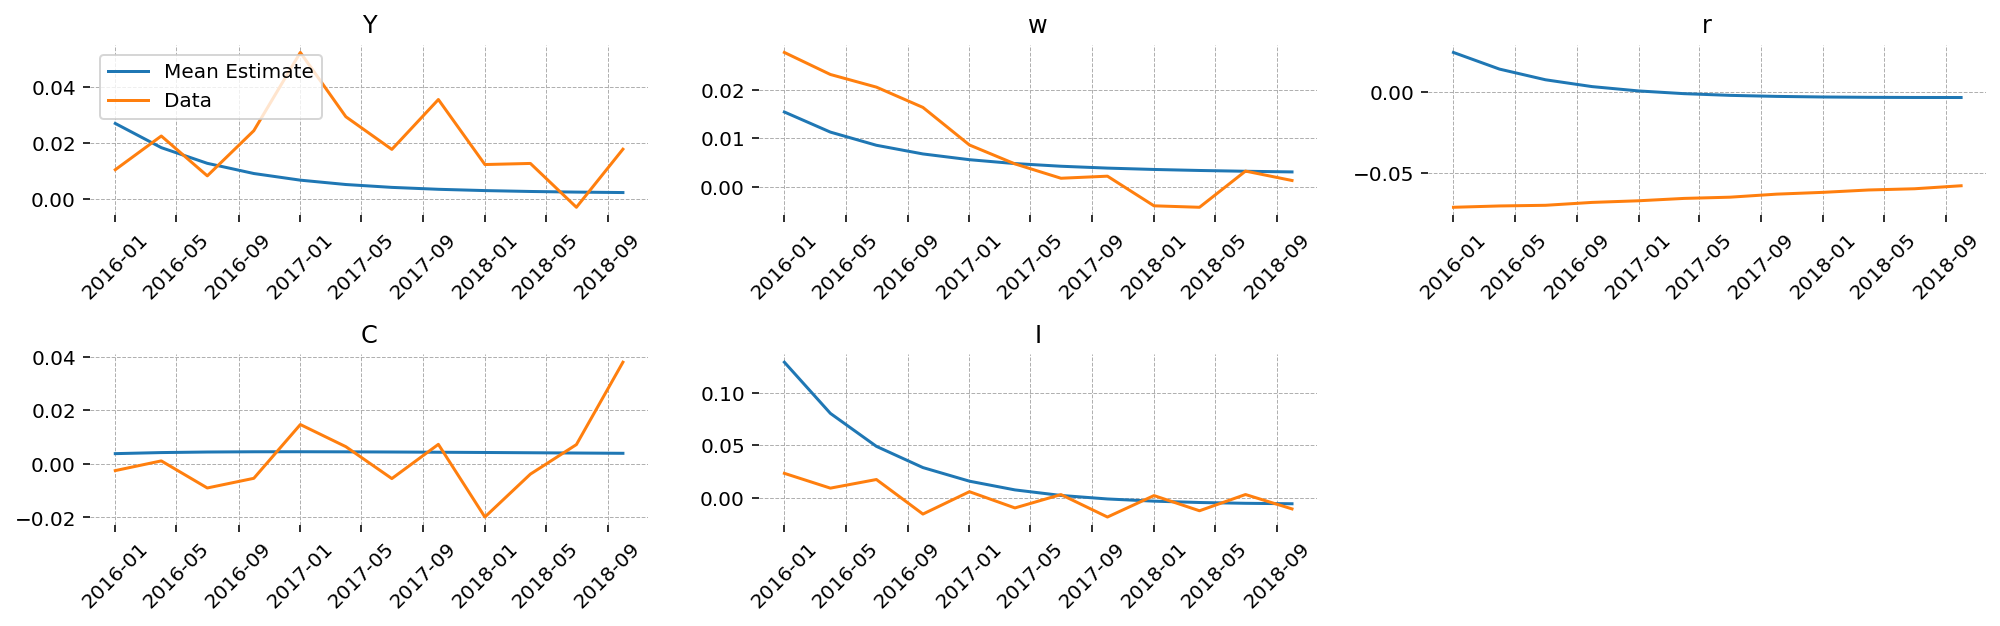

In [64]:
n_quarters = 12
gs, locs = gp.prepare_gridspec_figure(n_cols=3, n_plots=6)
sigma = 1.96 * np.sqrt(mle_forecast.var_pred_mean)

fig = plt.figure(figsize=(14, 6))
for var, loc in zip(['Y', 'w', 'r', 'C', 'I'], locs):
    axis = fig.add_subplot(gs[loc])
    axis.plot(mu[var].iloc[:n_quarters], label='Mean Estimate')
    axis.plot(test[var].iloc[:n_quarters], label='Data')
    axis.tick_params(axis='x', rotation=45)
    axis.set_title(var)

fig.axes[0].legend()
fig.tight_layout()
plt.show()

## Impulse response <a class="anchor" id="section_2_5"></a>

In [65]:
irf = rbc.impulse_response_function(simulation_length=40, shock_size=0.1)

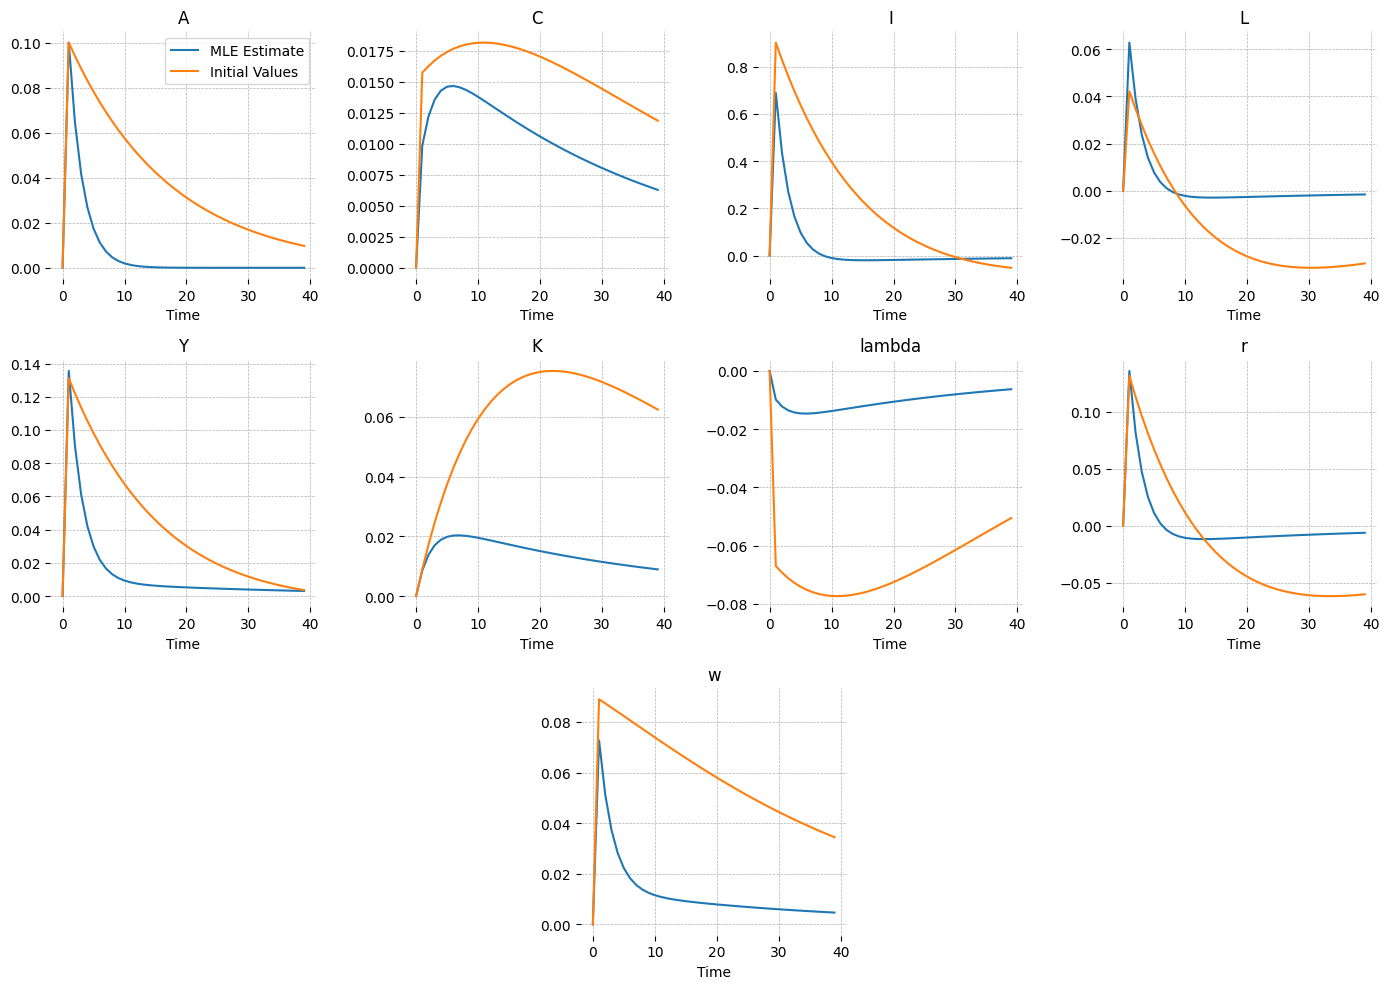

<Figure size 1400x1000 with 0 Axes>

In [66]:
fig = gp.plot_irf(irf.rename(columns={'epsilon_A':'MLE Estimate'}), vars_to_plot=plot_vars)
fig2 = gp.plot_irf(base_irf, vars_to_plot=plot_vars)

for axis, axis2 in zip(fig.axes, fig2.axes):
    line = axis2.get_children()[0]
    axis.plot(line.get_data()[0], line.get_data()[1], color='tab:orange', label='Initial Values')

    
fig.axes[0].legend()
fig2.clear()
fig2.set_visible(False)
plt.show()

We analyze a positive shock in productivy shock of 0.1. 
As we see starting from the analysis of productivity the shock will be assorbed quicker using MLE estimation, instead with the initial values it takes more time.
Consumption differes first in terms of reaction (more important using initial values), and also in terms of time to reassorbe the shock (quicker using estimation).
The same is true also for investment, but in the case of initial values they become negative after 30 quarters which compared also with the value of interest rate it doesn't make a lot of sense. 
Labor reacts less and also decrease more consistently in the case of the initial values. In both cases we can see the Lucas-Rapping effect.
The reaction in GDP is the same but then to return to the steady state is quicker for our new estimations
The dynamics of K is very different: using initial values K increase a lot for the first 20 quarters and then start to decrease, instead, using MLE it starts decreasing only after 5 quarters (more reasonable).
The interest rate fits well with capital, but it is in contraddiction with investments.
In the end, wages fit well with the dynamics of labor. The immediate reaction is due to the fact that in our RBC we don't have friction, or sticky prices.

### New Steady State <a class="anchor" id="subsection_2_9"></a>

The new steady state has significantly higher capital K_ss and Y_ss as the ex-ante model.

In [67]:
rbc.print_steady_state()

A_ss               1.000
C_ss               5.413
I_ss               1.231
K_ss              99.111
L_ss               0.833
Y_ss               6.644
lambda_ss          0.185
r_ss               0.029
w_ss               4.510
